# Predcition of Hospital Admission Related to Cough Cold

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to cough cold.

In [81]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.preprocessing import OneHotEncoder
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [82]:
# def create_lineplot(data, var, title, legend_title, ax1):
def create_lineplot(data, var, title, ax1):
    a = data.groupby(['date', var]).size().reset_index()
    a.columns = ['date', var, 'Freq']
    # a.Freq = a.Freq*1000
    a = a[a.Freq > 5]
    sns.lineplot(x='date', y='Freq', 
            hue=var, 
            data=a,
            ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel('Count')
    ax1.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=90)
#     ax1.legend(title=legend_title)
    # ax1.grid()
    ax1.axvline(x="2020-01", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2020-04", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2021-04", color='black', ls='--', lw=1.5)

In [83]:
# function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [84]:
def round_five_mul(x, base=5):
    return base * round(x/base)

In [85]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking_status', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'cough_cold_date_'+str(i), 'cough_cold_ab_date_'+str(i), 'cough_cold_ab_type_'+str(i),
                   'incdt_cough_cold_date_'+str(i), 'admitted_cough_cold_date_'+str(i), 'sgss_gp_cov_cough_cold_date_'+str(i)]]
    
    #drop rows with no cough_cold reord
    datum = datum[datum['cough_cold_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with cough_cold_i
    datum = datum[datum['sgss_gp_cov_cough_cold_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'cough_cold_date_'+str(i): 'cough_cold_date', 'cough_cold_ab_date_'+str(i): 'cough_cold_ab_date', 
                           'cough_cold_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_cough_cold_date_'+str(i): 'incdt_cough_cold_date', 'incdt_cough_cold_type_'+str(i): 'incdt_cough_cold_type',
                           'admitted_cough_cold_date_'+str(i): 'admitted_cough_cold_date',
                           'sgss_gp_cov_cough_cold_date_'+str(i): 'sgss_gp_cov_cough_cold_date'},
                inplace=True)
    
    return datum

In [86]:
def cox_data_prep(data, vars, vars_countinuous, vars_output):
    # data_req = data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit',
    #              'event_cough_cold_admitted', 'duration_cough_cold_admitted']]
    data_req = data[vars+vars_countinuous+vars_output]

    # encoding categorical data for CPH
    # data_enc = data_req[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit']].reset_index()
    data_enc = data_req[vars+vars_countinuous].reset_index()
    # data_enc

    # creating instance of one-hot-encoder
    enc = OneHotEncoder()
    results = enc.fit_transform(data_enc)
    data_req_enc = pd.DataFrame(enc.fit_transform(data_enc[vars]).toarray())
    data_req_enc.columns = enc.get_feature_names(data_enc[vars].columns)
    data_req_enc = data_enc[vars_countinuous].join(data_req_enc) 

    return data_req, data_req_enc

In [87]:
def make_summary_table(infection, infection_type, data):
    #summary table
    summary_table = data.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = data.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = data.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'
    # summary_table

    # save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [88]:
def make_summary_table_hosped(infection, infection_type, data):
    #keep hospitalised cses (events=1)
    data_hosped = data[data['event_'+infection+'_admitted'] == 1]

    # encoding categorical hosped data
    data_hosped = data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period', 'antibacterial_brit']].reset_index()
    # data_hosped

    # creating instance of one-hot-encoder
    enc = OneHotEncoder()
    results = enc.fit_transform(data_hosped)
    data_hosped_enc = pd.DataFrame(enc.fit_transform(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']]).toarray())
    data_hosped_enc.columns = enc.get_feature_names(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']].columns)
    data_hosped_enc = data_hosped[['antibacterial_brit']].join(data_hosped_enc)

    # data_hosped_enc#.head()
    #summary table for hosped cases
    summary_table_hosped = data_hosped_enc.sum(axis=0).reset_index()
    summary_table_hosped.columns = ['variable', 'count']
    summary_table_hosped['mean'] = data_hosped_enc.mean(axis=0).reset_index()[0]
    #round count to make last digit either 0 or 5
    summary_table_hosped['count'] = round_five_mul(summary_table_hosped['count'], base=5)
    summary_table_hosped['std'] = data_hosped_enc.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table_hosped.loc[(summary_table_hosped['count'] <= 5), 'count'] = 'SM'
    # summary_table_hosped

    # save table
    summary_table_hosped.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'_hosped.csv', index=False)

In [89]:
def cox_model_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #calculate and save ci
    ci = cph.concordance_index_
    a = open('../output/hospitalisation_prediction_'+infection+'/'+infection+'_'+infection_type+'_ci.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (ci)])

    return cph, data_train, data_test

In [90]:
def betas_sumbetas_calculate(cph, directory, betas_name, data_infection_enc, data_infection, sum_betas_name):

    # cleaning up covariates to make them compatible with the encoded data
    covariates = cph.params_.reset_index()#.hazard_ratios_
    covariates.covariate = covariates.covariate.str.replace("[","")
    covariates.covariate = covariates.covariate.str.replace("]","")
    covariates.covariate = covariates.covariate.str.replace("T.","_")
    # covariates.shape

    # save coefficients
    covariates.to_csv(directory+betas_name, index=False)

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv(directory+'hazard_ratios_'+betas_name, index=False)

    # transpose and sort covariates and coefficients
    covariatesT = covariates.T
    # covariatesT.covariate = covariates
    header = covariatesT.iloc[0]
    covariatesT = covariatesT[1:]
    covariatesT.columns = header
    covariatesT = covariatesT.sort_index(axis = 1) #sort covariates to match data
    # covariatesT.shape

    # further cleaning up covariates to make them compatible with the encoded data
    mylist = ["'" + item + "'" for item in covariates.covariate] #adds single quotation mark
    mylist = [value.replace("'", "") for value in mylist] #removes double quotation mark 

    #match mylist (covariates of cox model) with encoded data
    data = data_infection_enc[data_infection_enc.columns.intersection(mylist)] 
    data = data.sort_index(axis = 1) #sort 
    # data.shape

    # multiply betas and encoded data
    betas = data.multiply(np.array(covariatesT), axis='columns')
    # betas

    # sum up betas of each row to calculate sum of betas 
    sum_betas = betas.sum(axis=1)
    # sum_betas
#######################################################
    # predict cumulative hazard values at day 30 and match them with sum of betas
    sum_betas_hazard = cph.predict_cumulative_hazard(data_infection).loc[[30]].T.reset_index(drop=True)
    sum_betas_hazard['sum_betas'] = sum_betas
    # sum_betas_hazard

    #drop rows with predicted risks greater than 99th percentile of all risks
    sum_betas_hazard = sum_betas_hazard[sum_betas_hazard[30] <= sum_betas_hazard[30].quantile(0.99)]  
    # return sum_betas_hazard

    # sort values of sum of betas
    sum_betas_hazard = sum_betas_hazard.sort_values(by=['sum_betas'])
    # sum_betas_hazard

    # binning sum of betas into 100 bins
    sum_betas_hazard['bins'] = pd.cut(sum_betas_hazard['sum_betas'], 100) #100 intervals between min and max of sum_betas
    # sum_betas_hazard

    #calculate mean of cumulative hazar at day 30 by groupby 
    sum_betas_hazard_groupby = sum_betas_hazard.groupby(['bins'])[30.0].describe().reset_index()
    # sum_betas_hazard_groupby

    #calculate interpolation of missing mean values 
    sum_betas_hazard_groupby['mean_interpolate'] = sum_betas_hazard_groupby['mean'].interpolate(method='linear')

    # separate upper and lower boundries of bins
    sum_betas_hazard_groupby['bin_lower'] = sum_betas_hazard_groupby['bins'].map(attrgetter('left'))
    sum_betas_hazard_groupby['bin_upper'] = sum_betas_hazard_groupby['bins'].map(attrgetter('right'))
    # sum_betas_hazard_groupby.head()

    # select relevant columns including mean of cumulative hazard for each bin and the interpolation of means of cumulative hazard
    sum_betas = sum_betas_hazard_groupby[['bin_lower', 'bin_upper', 'mean_interpolate']]

    # save relevant columns of sum_betas
    sum_betas.to_csv(directory+sum_betas_name, index=False)

In [91]:
def cph_roc_curve(cph, event_col_name, data_train, data_test, directory, roc_name):
    # analysis of discrimination (training) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_train_cumulative_hazard = cph.predict_cumulative_hazard(data_train)
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.loc[[30]].T
    cph_train_cumulative_hazard[event_col_name] = data_train[event_col_name]
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
    # cph_train_cumulative_hazard

    # analysis of discrimination (testing) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_test_cumulative_hazard = cph.predict_cumulative_hazard(data_test)
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.loc[[30]].T
    cph_test_cumulative_hazard[event_col_name] = data_test[event_col_name]
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
    # cph_test_cumulative_hazard

    # plot roc curves
    r_fpr1, r_tpr1, _ = roc_curve(cph_train_cumulative_hazard[event_col_name], cph_train_cumulative_hazard.cumulative_hazard)
    r_fpr2, r_tpr2, _ = roc_curve(cph_test_cumulative_hazard[event_col_name], cph_test_cumulative_hazard.cumulative_hazard)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='Cox with development data')
    line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='Cox with validation data')

    squares = [0,1.01]
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)

    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=14)
    # plt.title('', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    # plt.tight_layout()
    plt.savefig(directory+'/'+roc_name, bbox_inches='tight')
    plt.show()

In [92]:
def cph_calibration(cph, data_train, event_name, data_test, directory, calib_train_name, calib_test_name):
    #predict cumulative hazard in day 30
    prob_pred_true_train = cph.predict_cumulative_hazard(data_train).loc[[30]].T
    prob_pred_true_train.columns = ['pred']
    # prob_pred_true_train

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)
    # prob_pred_true_train

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_train = pd.merge(prob_pred_true_train, data_train[event_name], left_index=True, right_index=True)
    # prob_pred_true_train

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']
    # prob_pred_true_train_groupby_bin

    #calculate proportion of events in each bin
    prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin['event_sum']/prob_pred_true_train_groupby_bin['event_count']
    # prob_pred_true_train_groupby_bin
############
    #predict cumulative hazard in day 30
    prob_pred_true_test = cph.predict_cumulative_hazard(data_test).loc[[30]].T #[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit', 'gp_count']]).loc[[30]].T#.reset_index(drop=True)
    prob_pred_true_test.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_test = pd.merge(prob_pred_true_test, data_test[event_name], left_index=True, right_index=True)

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

    #calculate proportion of events in each bin
    prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin['event_sum']/prob_pred_true_test_groupby_bin['event_count']
    # prob_pred_true_test_groupby_bin
###################
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    # plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_train_name, bbox_inches='tight')
    plt.show()

    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    # plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_test_name, bbox_inches='tight')
    plt.show()

In [93]:
def cph_output(cph, infection, infection_type, data_train, data_test, event_name, duration_name, directory):
    # calculate concordance index, AUROC, and Brier score of cph model
    concord_index_train = concordance_index(data_train[duration_name], -cph.predict_partial_hazard(data_train), data_train[event_name])
    concord_index_test = concordance_index(data_test[duration_name], -cph.predict_partial_hazard(data_test), data_test[event_name])
    
    # save model outputs
    a = open(directory+'cph_'+infection+'_'+infection_type+'_output.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (concord_index_train), 
                '\nConcordance index for '+infection+'_'+infection_type+' with validation data: %.4f' % (concord_index_test)])

In [94]:
def cox_model_abs_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + cough_cold_ab_date"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [95]:
def cox_model_ab_type_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + ab_type_cat"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [96]:
def cox_model_strat_sex_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + cough_cold_ab_date"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [97]:
def cox_model_strat_age_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + cough_cold_ab_date"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

## 1- data preparation

In [98]:
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_cough_cold.csv.gz')

data.shape

(200000, 224)

In [99]:
# save model outputs
a = open("../output/hospitalisation_prediction_cough_cold/data_cough_cold_record_cph_cough_cold.txt", "w")
a.write("")
a.writelines(['data_cough_cold_1 #with a record, #with no record: %.0f' % (data['cough_cold_date_1'].notna().sum()), ', %.0f' % (data['cough_cold_date_1'].isna().sum()),
              '\ndata_cough_cold_2 #with a record, #with no record: %.0f' % (data['cough_cold_date_2'].notna().sum()), ', %.0f' % (data['cough_cold_date_2'].isna().sum()),
              '\ndata_cough_cold_3 #with a record, #with no record: %.0f' % (data['cough_cold_date_3'].notna().sum()), ', %.0f' % (data['cough_cold_date_3'].isna().sum()),
              '\ndata_cough_cold_4 #with a record, #with no record: %.0f' % (data['cough_cold_date_4'].notna().sum()), ', %.0f' % (data['cough_cold_date_4'].isna().sum()),
              '\ndata_cough_cold_5 #with a record, #with no record: %.0f' % (data['cough_cold_date_5'].notna().sum()), ', %.0f' % (data['cough_cold_date_5'].isna().sum()),
              '\ndata_cough_cold_6 #with a record, #with no record: %.0f' % (data['cough_cold_date_6'].notna().sum()), ', %.0f' % (data['cough_cold_date_6'].isna().sum()),
              '\ndata_cough_cold_7 #with a record, #with no record: %.0f' % (data['cough_cold_date_7'].notna().sum()), ', %.0f' % (data['cough_cold_date_7'].isna().sum()),
              '\ndata_cough_cold_8 #with a record, #with no record: %.0f' % (data['cough_cold_date_8'].notna().sum()), ', %.0f' % (data['cough_cold_date_8'].isna().sum()),
              '\ndata_cough_cold_9 #with a record, #with no record: %.0f' % (data['cough_cold_date_9'].notna().sum()), ', %.0f' % (data['cough_cold_date_9'].isna().sum()),
              '\ndata_cough_cold_10 #with a record, #with no record: %.0f' % (data['cough_cold_date_10'].notna().sum()), ', %.0f' % (data['cough_cold_date_10'].isna().sum()),
              '\ndata_cough_cold_11 #with a record, #with no record: %.0f' % (data['cough_cold_date_11'].notna().sum()), ', %.0f' % (data['cough_cold_date_11'].isna().sum()),
              '\ndata_cough_cold_12 #with a record, #with no record: %.0f' % (data['cough_cold_date_12'].notna().sum()), ', %.0f' % (data['cough_cold_date_12'].isna().sum()),
              '\ndata_cough_cold_13 #with a record, #with no record: %.0f' % (data['cough_cold_date_13'].notna().sum()), ', %.0f' % (data['cough_cold_date_13'].isna().sum()),
              '\ndata_cough_cold_14 #with a record, #with no record: %.0f' % (data['cough_cold_date_14'].notna().sum()), ', %.0f' % (data['cough_cold_date_14'].isna().sum()),
              '\ndata_cough_cold_15 #with a record, #with no record: %.0f' % (data['cough_cold_date_15'].notna().sum()), ', %.0f' % (data['cough_cold_date_15'].isna().sum()),
              '\ndata_cough_cold_16 #with a record, #with no record: %.0f' % (data['cough_cold_date_16'].notna().sum()), ', %.0f' % (data['cough_cold_date_16'].isna().sum()),
              '\ndata_cough_cold_17 #with a record, #with no record: %.0f' % (data['cough_cold_date_17'].notna().sum()), ', %.0f' % (data['cough_cold_date_17'].isna().sum()),
              '\ndata_cough_cold_18 #with a record, #with no record: %.0f' % (data['cough_cold_date_18'].notna().sum()), ', %.0f' % (data['cough_cold_date_18'].isna().sum()),
              '\ndata_cough_cold_19 #with a record, #with no record: %.0f' % (data['cough_cold_date_19'].notna().sum()), ', %.0f' % (data['cough_cold_date_19'].isna().sum()),
              '\ndata_cough_cold_20 #with a record, #with no record: %.0f' % (data['cough_cold_date_20'].notna().sum()), ', %.0f' % (data['cough_cold_date_20'].isna().sum()),
              ])

### 1-2- additional variables
Calculating Charlson Comorbidity Index based on https://www.nature.com/articles/4500889.pdf?origin=ppub

In [100]:
data['CCI'] = np.nan
col0 = data.columns.get_loc('CCI')

col1 = data.columns.get_loc('cancer_comor')
col2 = data.columns.get_loc('cardiovascular_comor')
col3 = data.columns.get_loc('chronic_obstructive_pulmonary_comor') ##
col4 = data.columns.get_loc('heart_failure_comor') ##
col5 = data.columns.get_loc('connective_tissue_comor')
col6 = data.columns.get_loc('dementia_comor')
col7 = data.columns.get_loc('diabetes_comor')
col8 = data.columns.get_loc('diabetes_complications_comor')
col9 = data.columns.get_loc('hemiplegia_comor')
col10 = data.columns.get_loc('hiv_comor')
col11 = data.columns.get_loc('metastatic_cancer_comor')
col12 = data.columns.get_loc('mild_liver_comor')
col13 = data.columns.get_loc('mod_severe_liver_comor')
col14 = data.columns.get_loc('mod_severe_renal_comor')
col15 = data.columns.get_loc('mi_comor')
col16 = data.columns.get_loc('peptic_ulcer_comor')
col17 = data.columns.get_loc('peripheral_vascular_comor')


for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, col15] == 1: # mi_comor
        n=n+1
    if data.iat[idx, col2] == 1: # cardiovascular_comor
        n=n+1 
    if data.iat[idx, col17] == 1: # peripheral_vascular_comor
        n=n+1 
    if data.iat[idx, col3] == 1: # chronic_obstructive_pulmonary_comor
        n=n+1
    if data.iat[idx, col7] == 1: # diabetes_comor
        n=n+1
    if data.iat[idx, col6] == 1: # dementia_comor
        n=n+1
    if data.iat[idx, col16] == 1: # peptic_ulcer_comor
        n=n+1
    if data.iat[idx, col5] == 1: # connective_tissue_comor
        n=n+1
    if data.iat[idx, col12] == 1: # mild_liver_comor
        n=n+1
    if data.iat[idx, col9] == 1: # hemiplegia_comor
        n=n+2
    if data.iat[idx, col14] == 1: # mod_severe_renal_comor
        n=n+2
    if data.iat[idx, col8] == 1: # diabetes_complications_comor
        n=n+2
    if data.iat[idx, col1] == 1: # cancer_comor
        n=n+2
    if data.iat[idx, col13] == 1: # mod_severe_liver_comor
        n=n+3
    if data.iat[idx, col11] == 1: # metastatic_cancer_comor
        n=n+6
    if data.iat[idx, col10] == 1: # hiv_comor
        n=n+6
    
    data.iat[idx, col0]=n

data.CCI.value_counts()

0.0     37375
1.0     36934
2.0     32644
3.0     24651
4.0     15044
6.0     12223
7.0     10197
5.0      8492
8.0      7924
9.0      5798
10.0     3359
11.0     1867
12.0     1391
13.0      823
14.0      538
15.0      335
16.0      204
17.0      114
18.0       50
19.0       26
21.0        5
20.0        5
22.0        1
Name: CCI, dtype: int64

## 2- data preparation
This includes data type conversion and exclusion of cases that are not considered in the infection-related hospital admission, i.e. those who were diagnosed with Covid19 three months (=90 days) before and one month (=30 days) after hospital admission.

### 2-1- gathering data

In [101]:
#read 20 cough_colds and concatenate them 
data_cough_cold_1 = proc_infec_data(data,1)
data_cough_cold_2 = proc_infec_data(data,2)
data_cough_cold_3 = proc_infec_data(data,3)
data_cough_cold_4 = proc_infec_data(data,4)
data_cough_cold_5 = proc_infec_data(data,5)
data_cough_cold_6 = proc_infec_data(data,6)
data_cough_cold_7 = proc_infec_data(data,7)
data_cough_cold_8 = proc_infec_data(data,8)
data_cough_cold_9 = proc_infec_data(data,9)
data_cough_cold_10 = proc_infec_data(data,10)
data_cough_cold_11 = proc_infec_data(data,11)
data_cough_cold_12 = proc_infec_data(data,12)
data_cough_cold_13 = proc_infec_data(data,13)
data_cough_cold_14 = proc_infec_data(data,14)
data_cough_cold_15 = proc_infec_data(data,15)
data_cough_cold_16 = proc_infec_data(data,16)
data_cough_cold_17 = proc_infec_data(data,17)
data_cough_cold_18 = proc_infec_data(data,18)
data_cough_cold_19 = proc_infec_data(data,19)
data_cough_cold_20 = proc_infec_data(data,20)

data_cough_cold = pd.concat([data_cough_cold_1, data_cough_cold_2, data_cough_cold_3, data_cough_cold_4, data_cough_cold_5, data_cough_cold_6, data_cough_cold_7, data_cough_cold_8, data_cough_cold_9, data_cough_cold_10, data_cough_cold_11, data_cough_cold_12, data_cough_cold_13, data_cough_cold_14, data_cough_cold_15, data_cough_cold_16, data_cough_cold_17, data_cough_cold_18, data_cough_cold_19, data_cough_cold_20])
data_cough_cold.reset_index(inplace=True, drop=True)
data_cough_cold.shape

(360282, 20)

### 2-2- add season, event, and duration variables
#### season

In [102]:
# convert data types
data_cough_cold['cough_cold_date'] = data_cough_cold['cough_cold_date'].astype('datetime64[ns]')
data_cough_cold['admitted_cough_cold_date'] = data_cough_cold['admitted_cough_cold_date'].astype('datetime64[ns]')
data_cough_cold.died_date = data_cough_cold.died_date.astype('datetime64[ns]')
data_cough_cold.deregistered_date = data_cough_cold.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_cough_cold['date'] = data_cough_cold['cough_cold_date'] #gp_cons_cough_cold
data_cough_cold['date'] = data_cough_cold['date'].dt.strftime('%Y-%m')
print(f'min date: {data_cough_cold.date.min()}')
print(f'max date: {data_cough_cold.date.max()}')
print(f'length of data_cough_cold: {len(data_cough_cold)}')

min date: 2019-01
max date: 2020-01
length of data_cough_cold: 360282


In [103]:
#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')
# today_date_y_m

#drop any records of data_cough_cold with today's date in year and month
data_cough_cold = data_cough_cold[data_cough_cold['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_cough_cold = data_cough_cold[data_cough_cold['date'] != last_1_month_date_y_m]
data_cough_cold = data_cough_cold[data_cough_cold['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of cough_cold records
data_cough_cold['season'] = np.nan
data_cough_cold['date_month'] = pd.DatetimeIndex(data_cough_cold['date']).month

conditions = [
    (data_cough_cold['date_month'] >= 3) & (data_cough_cold['date_month'] <= 5),
    (data_cough_cold['date_month'] >= 6) & (data_cough_cold['date_month'] <= 8),
    (data_cough_cold['date_month'] >= 9) & (data_cough_cold['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_cough_cold['season'] = np.select(conditions, choices, default='winter')

print(data_cough_cold['season'].value_counts())
print(f'\nmin date: {data_cough_cold.date.min()}')
print(f'max date: {data_cough_cold.date.max()}')
print(f'length: {len(data_cough_cold)}')

spring    90881
summer    90761
autumn    89776
winter    88864
Name: season, dtype: int64

min date: 2019-01
max date: 2020-01
length: 360282


In [104]:
# data_cough_cold = data_cough_cold[data_cough_cold['date'] <= '2019-12']
# data_cough_cold = data_cough_cold[(data_cough_cold['date'] >= '2020-03') & (data_cough_cold['date']<= '2021-03')]
# data_cough_cold = data_cough_cold[data_cough_cold['date'] >= '2021-04']
# print(f'min date: {data_cough_cold.date.min()}')
# print(f'max date: {data_cough_cold.date.max()}')

In [105]:
#add period variable
data_cough_cold.loc[(data_cough_cold['date'] <= '2019-12'), 'period'] = 'prepandemic'
data_cough_cold.loc[((data_cough_cold['date'] >= '2020-01') & (data_cough_cold['date'] <= '2021-03')), 'period'] = 'during_pandemic'
data_cough_cold.loc[(data_cough_cold['date'] >= '2021-04'), 'period'] = 'post_2nd_lockdown'

#### event and duration

In [106]:
#scenario 1
#not hosped (nothing happened)
#data_cough_cold = data_cough_cold[data_cough_cold['admitted_cough_cold_date'].notnull()]
data_cough_cold.loc[data_cough_cold['admitted_cough_cold_date'].isnull(), 'event_cough_cold_admitted'] = 0
data_cough_cold['event_cough_cold_admitted'].value_counts()

0.0    252576
Name: event_cough_cold_admitted, dtype: int64

In [107]:
#scenario 2 
# become a case (uncensoring)
#calculating days between infection gp consultation and hosp
# data_cough_cold['delta_cough_cold_admitted'] = (data_cough_cold['admitted_cough_cold_date'] - data_cough_cold['cough_cold_date']).dt.days
data_cough_cold['delta_cough_cold_admitted'] = (data_cough_cold['admitted_cough_cold_date'] - data_cough_cold['cough_cold_date']).dt.days #gp_cons_cough_cold
data_cough_cold.loc[((data_cough_cold['delta_cough_cold_admitted'] >= 0) & (data_cough_cold['delta_cough_cold_admitted'] <= 30)), 'event_cough_cold_admitted'] = 1
# data_cough_cold['event_cough_cold_admitted'].value_counts()

#scenario 2
#drop whoever was admitted before cough_cold consultation, i.e. negative value for delta_cough_cold_admitted
data_cough_cold = data_cough_cold[~(data_cough_cold['delta_cough_cold_admitted'] < 0)]
data_cough_cold['delta_cough_cold_admitted'].value_counts()

26.0     310
5.0      306
2.0      301
8.0      300
1.0      299
        ... 
358.0      3
360.0      3
362.0      2
361.0      2
364.0      1
Name: delta_cough_cold_admitted, Length: 364, dtype: int64

In [108]:
#scenario 3
#censor died patients
data_cough_cold['delta_admitted_died'] = (data_cough_cold['died_date'] - data_cough_cold['admitted_cough_cold_date']).dt.days
data_cough_cold.loc[data_cough_cold['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
# data_cough_cold.loc[data_cough_cold['delta_admitted_died'] >= 0, 'event_cough_cold_admitted'] = 0
data_cough_cold.loc[((data_cough_cold['delta_admitted_died'] >= 0) & (data_cough_cold['delta_admitted_died'] <= 30)), 'event_cough_cold_admitted'] = 0
# data_cough_cold['event_cough_cold_admitted'].value_counts()

#scenario 3
#censor deregistered patients
data_cough_cold['delta_admitted_deregistered'] = (data_cough_cold['deregistered_date'] - data_cough_cold['admitted_cough_cold_date']).dt.days
data_cough_cold.loc[data_cough_cold['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
# data_cough_cold.loc[data_cough_cold['delta_admitted_deregistered'] >= 0, 'event_cough_cold_admitted'] = 0
data_cough_cold.loc[((data_cough_cold['delta_admitted_deregistered'] > 0) & (data_cough_cold['delta_admitted_deregistered'] <= 30)), 'event_cough_cold_admitted'] = 0
# data_cough_cold['event_cough_cold_admitted'].value_counts()

#agg scenario 3s
data_cough_cold['delta_admitted_died_deregistered'] = data_cough_cold['delta_admitted_deregistered'].combine_first(data_cough_cold['delta_admitted_died'])
data_cough_cold.loc[data_cough_cold['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN
data_cough_cold['delta_admitted_died_deregistered'].isnull().sum()#.value_counts()

301138

In [109]:
#scenario 1
#any other patients (nothing happened)
data_cough_cold['event_cough_cold_admitted'] = data_cough_cold['event_cough_cold_admitted'].replace(np.NaN, 0)
data_cough_cold['event_cough_cold_admitted'].value_counts()

0.0    297819
1.0      8682
Name: event_cough_cold_admitted, dtype: int64

In [110]:
#assign values for duration column
data_cough_cold['duration_cough_cold_admitted'] = data_cough_cold['delta_cough_cold_admitted'].combine_first(data_cough_cold['delta_admitted_died_deregistered'])
data_cough_cold['duration_cough_cold_admitted'] = data_cough_cold['duration_cough_cold_admitted'].replace(np.NaN, 30)
data_cough_cold.loc[(data_cough_cold['duration_cough_cold_admitted'] > 30), 'duration_cough_cold_admitted'] = 30
data_cough_cold['duration_cough_cold_admitted'].value_counts()

30.0    297980
26.0       310
5.0        306
2.0        301
8.0        300
1.0        299
21.0       298
13.0       296
0.0        294
16.0       293
22.0       293
18.0       292
10.0       292
15.0       288
19.0       284
9.0        284
27.0       284
24.0       283
20.0       280
4.0        279
14.0       279
28.0       278
7.0        276
11.0       275
17.0       275
29.0       273
6.0        273
25.0       262
3.0        261
12.0       257
23.0       256
Name: duration_cough_cold_admitted, dtype: int64

In [111]:
# give value 1 to event_cough_cold_admitted if duration_cough_cold_admitted is greater or equal to 0 and less than 30
data_cough_cold.loc[((data_cough_cold['duration_cough_cold_admitted'] >= 0) & (data_cough_cold['duration_cough_cold_admitted'] < 30)), 'event_cough_cold_admitted'] = 1
data_cough_cold['event_cough_cold_admitted'].value_counts()

0.0    297706
1.0      8795
Name: event_cough_cold_admitted, dtype: int64

In [112]:
#drop any rows with value 0 in duration column
data_cough_cold = data_cough_cold[~(data_cough_cold['duration_cough_cold_admitted'] == 0)]

#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_cough_cold.loc[((data_cough_cold['delta_cough_cold_admitted'] > 0) & (data_cough_cold['delta_cough_cold_admitted'] < 30)), 'event_cough_cold_admitted'] = 1

In [113]:
# data_cough_cold[data_cough_cold['duration_cough_cold_admitted']==0][['delta_cough_cold_admitted', 'cough_cold_date', 'gp_cons_cough_cold', 'admitted_cough_cold_date', 'delta_cough_cold_admitted', 'delta_admitted_died_deregistered', 'event_cough_cold_admitted', 'duration_cough_cold_admitted']]
# data_cough_cold.loc[151:200, ['event_cough_cold_admitted', 'duration_cough_cold_admitted']]
# data_cough_cold.loc[201:250, ['event_cough_cold_admitted', 'duration_cough_cold_admitted']].sort_values(by=['duration_cough_cold_admitted'])
data_cough_cold[['event_cough_cold_admitted', 'duration_cough_cold_admitted']].sort_values(by=['duration_cough_cold_admitted'])

,event_cough_cold_admitted,duration_cough_cold_admitted
325803,1.0,1.0
298689,1.0,1.0
132589,1.0,1.0
86010,1.0,1.0
16718,1.0,1.0
...,...,...
121646,0.0,30.0
121645,0.0,30.0
121644,0.0,30.0
121665,0.0,30.0


### 2-3- dealing with uninteresting and missing values

In [114]:
# prep before plot
data_cough_cold['age'][data_cough_cold['age'] < 0] = np.nan
data_cough_cold = data_cough_cold[data_cough_cold['age_cat'] != '0-4']
data_cough_cold = data_cough_cold[data_cough_cold['age_cat'] != '5-14']
# drop anybody with age less than 18
data_cough_cold = data_cough_cold[~(data_cough_cold['age'] < 18)]  
print(f'Min age: {data_cough_cold.age.min()}')

## remove died cases
#data_cough_cold.died_date.value_counts()

# assign 0 (missingness) to all bmi values less than 10
data_cough_cold['bmi'][data_cough_cold['bmi'] < 10] = 0
# replace 0s with nans
data_cough_cold['bmi'] = data_cough_cold['bmi'].replace({0:np.nan})

# remove cases with negative antibacterial_brit
data_cough_cold['antibacterial_brit'][data_cough_cold['antibacterial_brit'] < 0] = np.nan

Min age: 18


In [115]:
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_cough_cold = data_cough_cold.replace({"sex": dict_sex})
# data_bmi = data_bmi.replace({"sex": dict_sex})
data_cough_cold = data_cough_cold.replace({"smoking_status": dict_smoking})

In [116]:
if ('region' in data_cough_cold.columns) and (data_cough_cold['region'].isnull().sum() > 0):
    # drop region value missing
    # data_cough_cold['region_imp'] = data_cough_cold['region']
    print(f'Cound of missing values in variable region before dropping rows with possible missing values: {data_cough_cold.region.isnull().sum()}')
    data_cough_cold = data_cough_cold[data_cough_cold['region'].notna()]

print(f'Cound of missing values in variable region: {data_cough_cold.region.isnull().sum()}')
print(f'Count of categories of variable region: \n{data_cough_cold.region.value_counts()}')

Cound of missing values in variable region: 0
Count of categories of variable region: 
London                      36815
North East                  18821
South West                  18770
North West                  18663
East Midlands               18529
East                        18519
West Midlands               18429
South East                  18425
Yorkshire and The Humber    18375
Name: region, dtype: int64


In [117]:
if ('antibacterial_brit' in data_cough_cold.columns) and (data_cough_cold['antibacterial_brit'].isnull().sum() > 0):
    print(f'Cound of missing values in variable antibacterial_brit before changing NANs to zeros: {data_cough_cold.antibacterial_brit.isnull().sum()}')
    print(f'Mean of antibacterial_brit values before changing NAN to zeros: {data_cough_cold.antibacterial_brit.mean():.3f}')
    data_cough_cold['antibacterial_brit'] = data_cough_cold['antibacterial_brit'].fillna(0)
    # data_cough_cold['antibacterial_brit'] = data_cough_cold['antibacterial_brit'].replace({'0':np.nan, 0:np.nan})

print(f'\nCound of missing values in variable antibacterial_brit after changing NANs to zeros: {data_cough_cold.antibacterial_brit.isnull().sum()}')
print(f'Mean of antibacterial_brit values after changing NANs to zeros: {data_cough_cold.antibacterial_brit.mean():.3f}')

Cound of missing values in variable antibacterial_brit before changing NANs to zeros: 7
Mean of antibacterial_brit values before changing NAN to zeros: 1.258

Cound of missing values in variable antibacterial_brit after changing NANs to zeros: 0
Mean of antibacterial_brit values after changing NANs to zeros: 1.258


In [118]:
if ('ethnicity' in data_cough_cold.columns) and (data_cough_cold['ethnicity'].isnull().sum() > 0):
    print(f'Count of missing values in variable ethnicity before changing them to Unknown category: {data_cough_cold.ethnicity.isnull().sum()}')
    print(f'Count of categories of variable ethnicity before changing them to Unknown category: \n{data_cough_cold.ethnicity.value_counts()}')
    # data_cough_cold['ethnicity'] = data_cough_cold['ethnicity'].astype(str)
    data_cough_cold['ethnicity'] = data_cough_cold['ethnicity'].fillna(0)

print(f'\nCound of missing values in variable ethnicity after changing NANs to Unknown category: {data_cough_cold.ethnicity.isnull().sum()}')
print(f'Count of categories of variable ethnicity after changing NANs to Unknown category: \n{data_cough_cold.ethnicity.value_counts()}')

Count of missing values in variable ethnicity before changing them to Unknown category: 46009
Count of categories of variable ethnicity before changing them to Unknown category: 
1.0    111108
5.0     14121
3.0     14108
Name: ethnicity, dtype: int64

Cound of missing values in variable ethnicity after changing NANs to Unknown category: 0
Count of categories of variable ethnicity after changing NANs to Unknown category: 
1.0    111108
0.0     46009
5.0     14121
3.0     14108
Name: ethnicity, dtype: int64


In [119]:
if ('smoking_status' in data_cough_cold.columns) and (data_cough_cold['smoking_status'].isnull().sum() > 0):
    print(f'Count of missing values in variable smoking_status before changing them to Unknown category: {data_cough_cold.smoking_status.isnull().sum()}')
    print(f'Count of categories of variable smoking_status before changing them to Unknown category: \n{data_cough_cold.smoking_status.value_counts()}')
    # data_cough_cold['smoking_status'] = data_cough_cold['smoking_status'].astype(str)
    data_cough_cold['smoking_status'] = data_cough_cold['smoking_status'].fillna(0)

print(f'\nCound of missing values in variable smoking_status after changing NANs to Unknown category: {data_cough_cold.smoking_status.isnull().sum()}')
print(f'Count of categories of variable smoking_status after changing NANs to Unknown category: \n{data_cough_cold.smoking_status.value_counts()}')

Count of missing values in variable smoking_status before changing them to Unknown category: 76760
Count of categories of variable smoking_status before changing them to Unknown category: 
1.0    72620
3.0    23809
2.0    12157
Name: smoking_status, dtype: int64

Cound of missing values in variable smoking_status after changing NANs to Unknown category: 0
Count of categories of variable smoking_status after changing NANs to Unknown category: 
0.0    76760
1.0    72620
3.0    23809
2.0    12157
Name: smoking_status, dtype: int64


In [120]:
if ('imd' in data_cough_cold.columns) and (data_cough_cold['imd'].isnull().sum() > 0):
    print(f'Count of missing values in variable imd before changing them to Unknown category: {data_cough_cold.imd.isnull().sum()}')
    print(f'Count of categories of variable imd before changing them to Unknown category: \n{data_cough_cold.imd.value_counts()}')
    # data_cough_cold['imd'] = data_cough_cold['imd'].astype(str)
    data_cough_cold['imd'] = data_cough_cold['imd'].fillna(0)

print(f'\nCound of missing values in variable imd after changing NANs to Unknown category: {data_cough_cold.imd.isnull().sum()}')
print(f'Count of categories of variable imd after changing NANs to Unknown category: \n{data_cough_cold.imd.value_counts()}')


Cound of missing values in variable imd after changing NANs to Unknown category: 0
Count of categories of variable imd after changing NANs to Unknown category: 
2    35464
4    35318
5    35261
1    35238
3    34873
0     9192
Name: imd, dtype: int64


In [121]:
data_cough_cold['bmi_cat'] = 5
col_bmi_cat = data_cough_cold.columns.get_loc('bmi_cat')

col_sex = data_cough_cold.columns.get_loc('sex')
col_age = data_cough_cold.columns.get_loc('age')
col_bmi = data_cough_cold.columns.get_loc('bmi')

for idx, x in enumerate(data_cough_cold['bmi_cat']):
    if data_cough_cold.iat[idx, col_bmi] >= 30:
        data_cough_cold.iat[idx, col_bmi_cat] = 1 #'Obese'
    if (data_cough_cold.iat[idx, col_bmi] >= 25) and (data_cough_cold.iat[idx, col_bmi] < 30):
        data_cough_cold.iat[idx, col_bmi_cat] = 2 #'Overweight'
    if (data_cough_cold.iat[idx, col_bmi] >= 18.5) and (data_cough_cold.iat[idx, col_bmi] < 25):
        data_cough_cold.iat[idx, col_bmi_cat] = 3 #'Healthy weight'
    if data_cough_cold.iat[idx, col_bmi] < 18.5:
        data_cough_cold.iat[idx, col_bmi_cat] = 4 #'Underweight'

data_cough_cold['bmi_cat'].value_counts()

1    96130
5    47266
2    20756
3    15077
4     6117
Name: bmi_cat, dtype: int64

In [122]:
if ('bmi_cat' in data_cough_cold.columns) and (data_cough_cold['bmi_cat'].isnull().sum() > 0):
    print(f'Count of missing values in variable bmi_cat before changing them to Unknown category: {data_cough_cold.bmi_cat.isnull().sum()}')
    print(f'Count of categories of variable bmi_cat before changing them to Unknown category: \n{data_cough_cold.bmi_cat.value_counts()}')
    # data_cough_cold['bmi_cat'] = data_cough_cold['bmi_cat'].astype(str)
    data_cough_cold['bmi_cat'] = data_cough_cold['bmi_cat'].fillna(0)

print(f'\nCound of missing values in variable bmi_cat after changing NANs to Unknown category: {data_cough_cold.bmi_cat.isnull().sum()}')
print(f'Count of categories of variable bmi_cat after changing NANs to Unknown category: \n{data_cough_cold.bmi_cat.value_counts()}')


Cound of missing values in variable bmi_cat after changing NANs to Unknown category: 0
Count of categories of variable bmi_cat after changing NANs to Unknown category: 
1    96130
5    47266
2    20756
3    15077
4     6117
Name: bmi_cat, dtype: int64


In [123]:
#add variable ab_type_cat
#find ab types
ab_series = pd.value_counts(data_cough_cold.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_cough_cold['ab_type_cat'] = np.where(data_cough_cold['ab_type'].isin(ab_series[mask].index),'other',data_cough_cold['ab_type'])

#assign no to non ab users
data_cough_cold.loc[data_cough_cold['cough_cold_ab_date'].isnull(), 'ab_type_cat'] = 'no'

#fill nas with 0 and then assign other to 0s
data_cough_cold['ab_type_cat'] = data_cough_cold['ab_type_cat'].fillna(0)
data_cough_cold['ab_type_cat'].value_counts()

no             166751
0               14857
other            2263
Amoxicillin      1118
Doxycycline       357
Name: ab_type_cat, dtype: int64

### 2-4- translate values of categorical variables

In [124]:
# define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'non-white', 3.0: 'non-white', 4.0: 'non-white', 5.0: 'non-white', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

In [125]:
# reoplace values of dictionaries with existing ones
data_cough_cold = data_cough_cold.replace({"sex": dict_sex})
data_cough_cold = data_cough_cold.replace({"ethnicity": dict_ethnicity})
data_cough_cold = data_cough_cold.replace({"smoking_status": dict_smoking})
data_cough_cold = data_cough_cold.replace({"imd": dict_imd})
data_cough_cold = data_cough_cold.replace({"bmi_cat": dict_bmi})
data_cough_cold = data_cough_cold.replace({"flu_vaccine": dict_flu})
data_cough_cold = data_cough_cold.replace({"region": dict_region})
data_cough_cold = data_cough_cold.replace({"age_cat": dict_age})
data_cough_cold = data_cough_cold.replace({"ab_type_cat": dict_ab_type})
data_cough_cold['ab_type_cat'].value_counts()

no             166751
other           17120
Amoxicillin      1118
Doxycycline       357
Name: ab_type_cat, dtype: int64

### 2-5- categorising and assigning max value for continuous variables

In [126]:
# categorising
data_cough_cold['CCI_cat'] = pd.cut(data_cough_cold['CCI'], right=False, bins=[0,1,3,5,7,10000000000], labels=['very_low', 'low', 'medium', 'high', 'very_high'])
data_cough_cold['CCI_cat'].value_counts()

low          64080
medium       37192
very_low     34631
very_high    30282
high         19161
Name: CCI_cat, dtype: int64

In [127]:
# assign max value to outliers (beyond 95 percentile)
data_cough_cold['antibacterial_brit'].clip(0, data_cough_cold['antibacterial_brit'].quantile(0.95), inplace=True)
data_cough_cold['antibacterial_brit'].max()

data_cough_cold['antibacterial_brit_cat'] = pd.cut(data_cough_cold['antibacterial_brit'], 3, labels=['low', 'medium', 'high'])
data_cough_cold['antibacterial_brit_cat'].value_counts()

low       106937
high       46641
medium     31768
Name: antibacterial_brit_cat, dtype: int64

## 3- plots

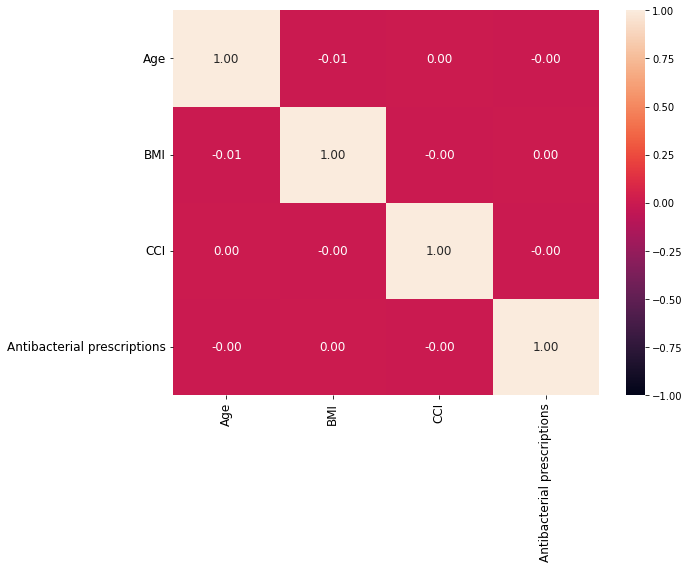

In [128]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data_cough_cold[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=12)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=12)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_cough_cold/corr_cough_cold.jpg')
plt.show()

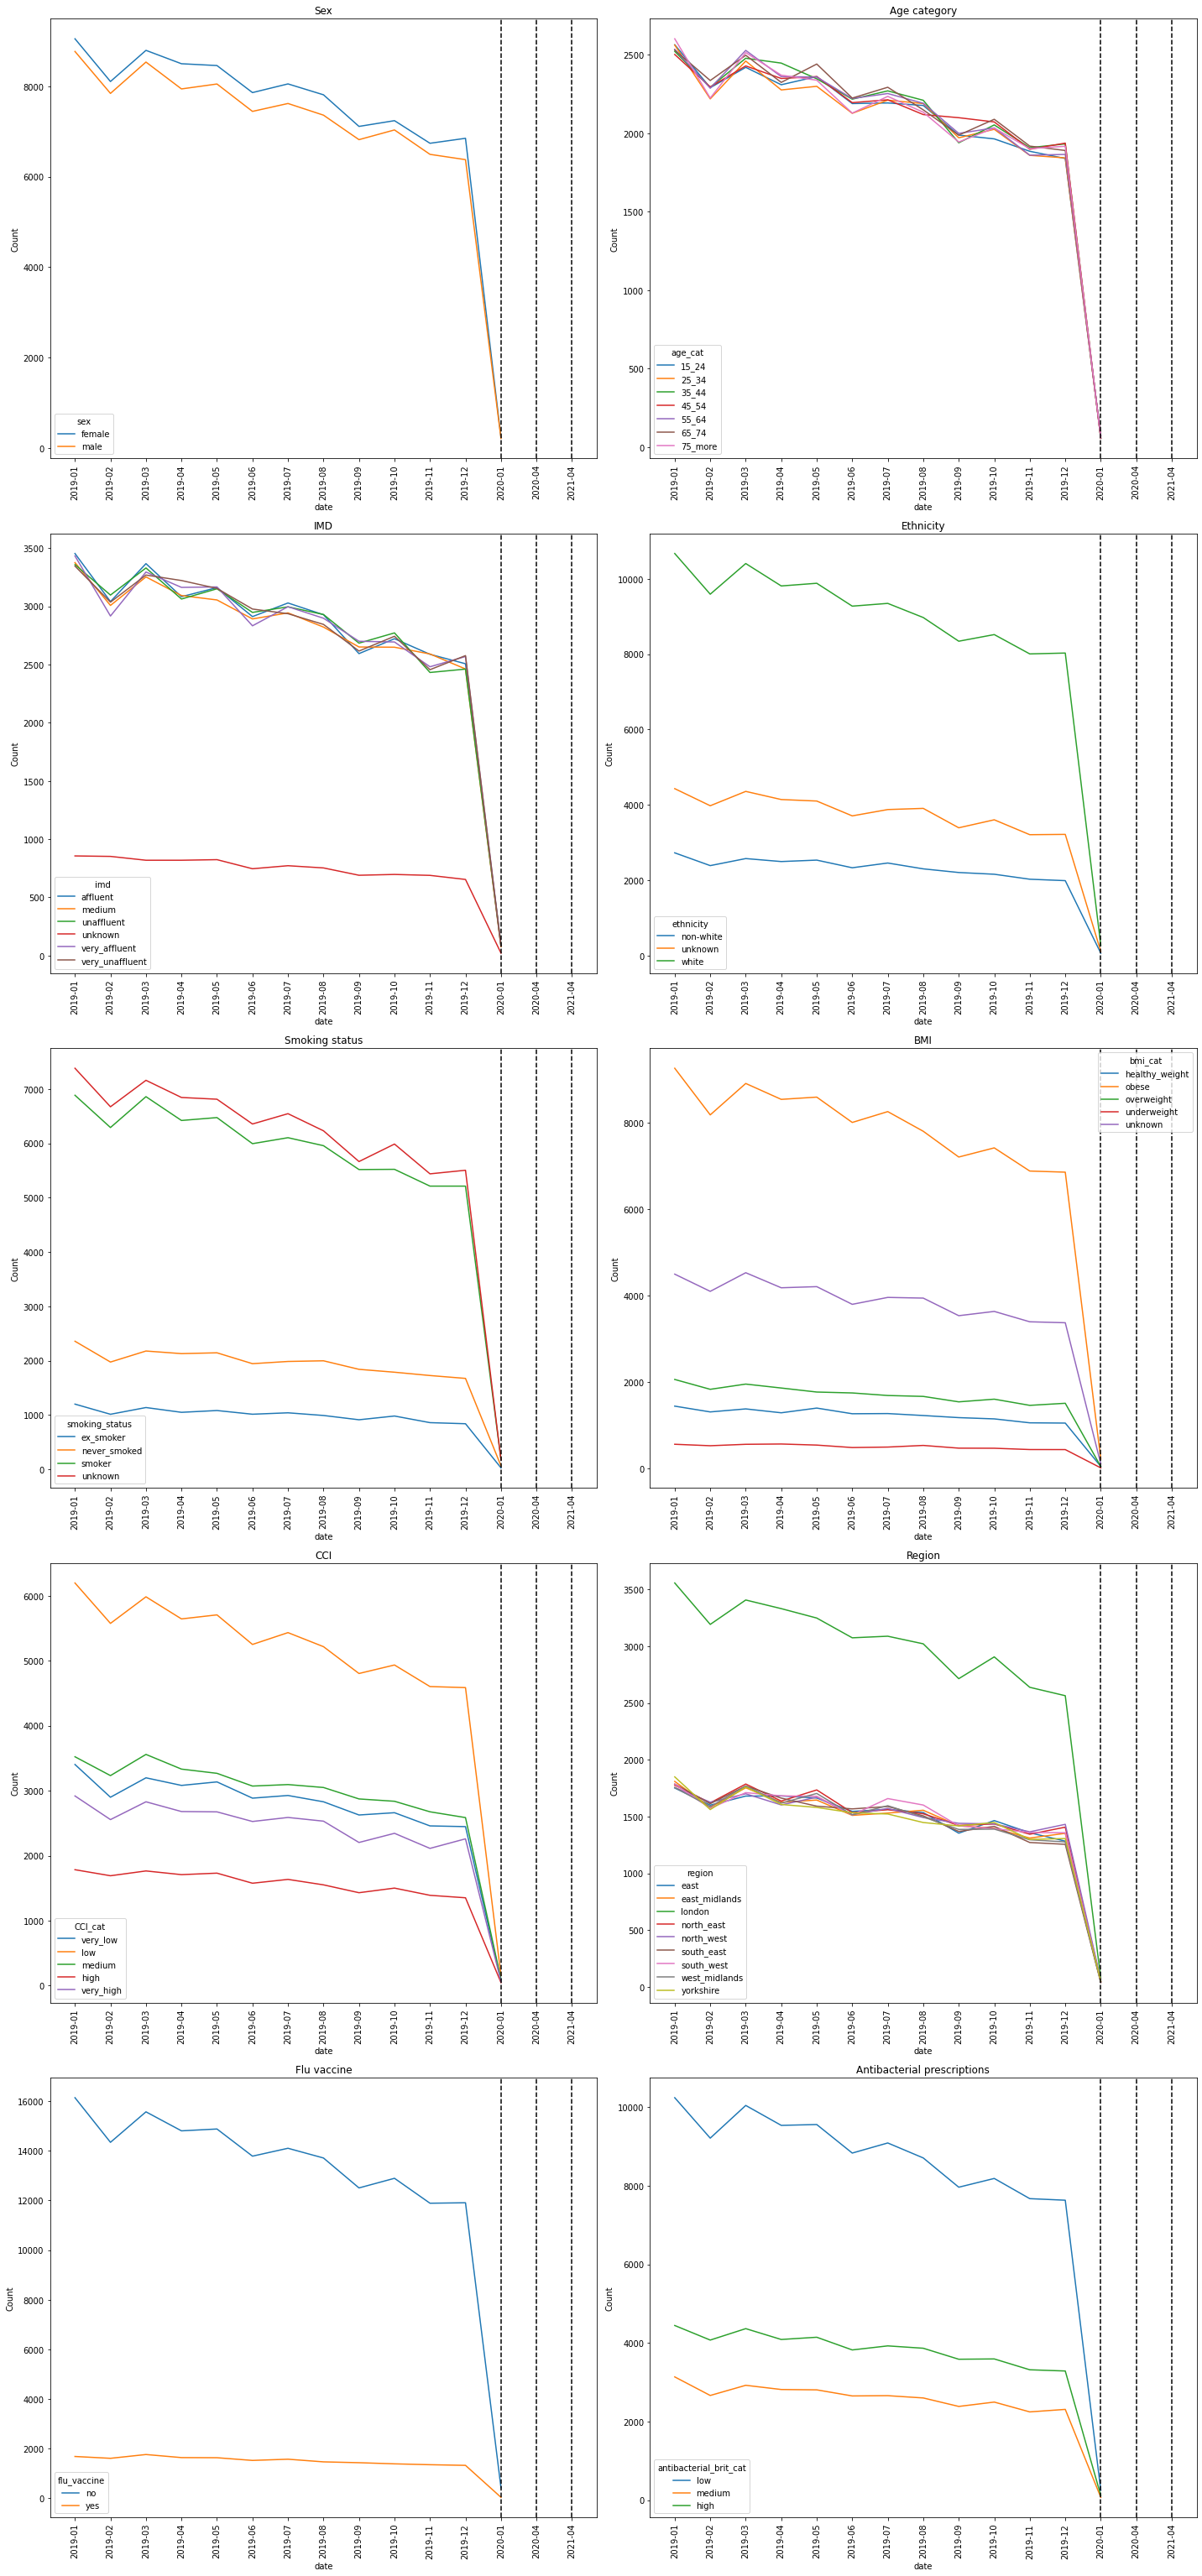

In [129]:
fig, axes = plt.subplots(5,2,
                        figsize=(20, 45)
                        )
create_lineplot(data_cough_cold, 'sex', 'Sex', axes[0,0])
create_lineplot(data_cough_cold, 'age_cat', 'Age category', axes[0,1])
create_lineplot(data_cough_cold, 'imd', 'IMD', axes[1,0])
create_lineplot(data_cough_cold, 'ethnicity', 'Ethnicity', axes[1,1])
create_lineplot(data_cough_cold, 'smoking_status', 'Smoking status', axes[2,0])
create_lineplot(data_cough_cold, 'bmi_cat', 'BMI', axes[2,1])
create_lineplot(data_cough_cold, 'CCI_cat', 'CCI', axes[3,0])
create_lineplot(data_cough_cold, 'region', 'Region', axes[3,1])
create_lineplot(data_cough_cold, 'flu_vaccine', 'Flu vaccine', axes[4,0])
create_lineplot(data_cough_cold, 'antibacterial_brit_cat', 'Antibacterial prescriptions', axes[4,1])
# fig.delaxes(ax=axes[5,1])

# fig.suptitle('Risk Factors of cough_cold patients', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
#plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_cough_cold/risk_factors_cat_cough_cold.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics
We separate data of cough_cold to form four sub-datasets for 1) no antibiotics and incident admission, 2) with antibiotics and incident admission, 3) no antibiotics and prevalent admission, and 4) with antiobiotics and prevalent admission.

In [130]:
data_cough_cold = data_cough_cold[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 
                       'antibacterial_brit', 'cough_cold_ab_date', 'ab_type_cat', 'incdt_cough_cold_date', 'date', 'period',
                       'event_cough_cold_admitted', 'duration_cough_cold_admitted'
                        ]]

data_cough_cold.shape

(185346, 18)

In [131]:
#incident and prevalent infection 
data_cough_cold_incdt = data_cough_cold[data_cough_cold['incdt_cough_cold_date'] == 0]
data_cough_cold_prevl = data_cough_cold[data_cough_cold['incdt_cough_cold_date'] == 1]
#switch variable cough_cold_ab_date into a binary variable
data_cough_cold_incdt[['cough_cold_ab_date']] = data_cough_cold_incdt[['cough_cold_ab_date']].where(data_cough_cold_incdt[['cough_cold_ab_date']].isnull(), 1).fillna(0).astype(int)
data_cough_cold_prevl[['cough_cold_ab_date']] = data_cough_cold_prevl[['cough_cold_ab_date']].where(data_cough_cold_prevl[['cough_cold_ab_date']].isnull(), 1).fillna(0).astype(int)

#incident and prevalent infection stratified by sex categories
data_cough_cold_incdt_males = data_cough_cold_incdt[data_cough_cold_incdt['sex'] == 'male']
data_cough_cold_incdt_females = data_cough_cold_incdt[data_cough_cold_incdt['sex'] == 'female']
data_cough_cold_prevl_males = data_cough_cold_prevl[data_cough_cold_prevl['sex'] == 'male']
data_cough_cold_prevl_females = data_cough_cold_prevl[data_cough_cold_prevl['sex'] == 'female']

#incident and prevalent infection stratified by age categories
data_cough_cold_incdt_15_24 = data_cough_cold_incdt[data_cough_cold_incdt['age_cat'] == '15_24']
data_cough_cold_incdt_25_34 = data_cough_cold_incdt[data_cough_cold_incdt['age_cat'] == '25_34']
data_cough_cold_incdt_35_44 = data_cough_cold_incdt[data_cough_cold_incdt['age_cat'] == '35_44']
data_cough_cold_incdt_45_54 = data_cough_cold_incdt[data_cough_cold_incdt['age_cat'] == '45_54']
data_cough_cold_incdt_55_64 = data_cough_cold_incdt[data_cough_cold_incdt['age_cat'] == '55_64']
data_cough_cold_incdt_65_74 = data_cough_cold_incdt[data_cough_cold_incdt['age_cat'] == '65_74']
data_cough_cold_incdt_75_more = data_cough_cold_incdt[data_cough_cold_incdt['age_cat'] == '75_more']
data_cough_cold_prevl_15_24 = data_cough_cold_prevl[data_cough_cold_prevl['age_cat'] == '15_24']
data_cough_cold_prevl_25_34 = data_cough_cold_prevl[data_cough_cold_prevl['age_cat'] == '25_34']
data_cough_cold_prevl_35_44 = data_cough_cold_prevl[data_cough_cold_prevl['age_cat'] == '35_44']
data_cough_cold_prevl_45_54 = data_cough_cold_prevl[data_cough_cold_prevl['age_cat'] == '45_54']
data_cough_cold_prevl_55_64 = data_cough_cold_prevl[data_cough_cold_prevl['age_cat'] == '55_64']
data_cough_cold_prevl_65_74 = data_cough_cold_prevl[data_cough_cold_prevl['age_cat'] == '65_74']
data_cough_cold_prevl_75_more = data_cough_cold_prevl[data_cough_cold_prevl['age_cat'] == '75_more']

data_cough_cold_incdt_prepandemic = data_cough_cold_incdt[data_cough_cold_incdt['date'] <= '2019-12']
data_cough_cold_incdt_during_pandemic = data_cough_cold_incdt[(data_cough_cold_incdt['date'] >= '2020-03') & (data_cough_cold_incdt['date']<= '2021-03')]
data_cough_cold_incdt_post_2nd_lockdown = data_cough_cold_incdt[data_cough_cold_incdt['date'] <= '2021-04']
data_cough_cold_prevl_prepandemic = data_cough_cold_prevl[data_cough_cold_prevl['date'] <= '2019-12']
data_cough_cold_prevl_during_pandemic = data_cough_cold_prevl[(data_cough_cold_prevl['date'] >= '2020-03') & (data_cough_cold_prevl['date']<= '2021-03')]
data_cough_cold_prevl_post_2nd_lockdown = data_cough_cold_prevl[data_cough_cold_prevl['date'] <= '2021-04']

# #incident and prevalent infection stratified by ab categories
# data_cough_cold_incdt_abtype_0 = data_cough_cold_incdt[data_cough_cold_incdt['ab_type_cat'] == data_cough_cold['ab_type_cat'].unique()[0]]
# data_cough_cold_incdt_abtype_1 = data_cough_cold_incdt[data_cough_cold_incdt['ab_type_cat'] == data_cough_cold['ab_type_cat'].unique()[1]]
# data_cough_cold_incdt_abtype_2 = data_cough_cold_incdt[data_cough_cold_incdt['ab_type_cat'] == data_cough_cold['ab_type_cat'].unique()[2]]
# data_cough_cold_incdt_abtype_3 = data_cough_cold_incdt[data_cough_cold_incdt['ab_type_cat'] == data_cough_cold['ab_type_cat'].unique()[3]]
# data_cough_cold_prevl_abtype_0 = data_cough_cold_prevl[data_cough_cold_prevl['ab_type_cat'] == data_cough_cold['ab_type_cat'].unique()[0]]
# data_cough_cold_prevl_abtype_1 = data_cough_cold_prevl[data_cough_cold_prevl['ab_type_cat'] == data_cough_cold['ab_type_cat'].unique()[1]]
# data_cough_cold_prevl_abtype_2 = data_cough_cold_prevl[data_cough_cold_prevl['ab_type_cat'] == data_cough_cold['ab_type_cat'].unique()[2]]
# data_cough_cold_prevl_abtype_3 = data_cough_cold_prevl[data_cough_cold_prevl['ab_type_cat'] == data_cough_cold['ab_type_cat'].unique()[3]]

# #incident and prevalent infection with antibiotics type
# data_cough_cold_incdt_abs = data_cough_cold_incdt[data_cough_cold_incdt['cough_cold_ab_date'] == 1]
# data_cough_cold_prevl_abs = data_cough_cold_prevl[data_cough_cold_prevl['cough_cold_ab_date'] == 1]

# no antibiotics and incident hospital admission
data_cough_cold_no_abs_incdt = data_cough_cold[data_cough_cold['cough_cold_ab_date'].isnull()] #gp_cons_cough_cold_ab
data_cough_cold_no_abs_incdt = data_cough_cold_no_abs_incdt[data_cough_cold_no_abs_incdt['incdt_cough_cold_date'] == 0]

# with antibiotics and incident hospital admission
data_cough_cold_abs_incdt = data_cough_cold[data_cough_cold['cough_cold_ab_date'].notnull()]
data_cough_cold_abs_incdt = data_cough_cold_abs_incdt[data_cough_cold_abs_incdt['incdt_cough_cold_date'] == 0]

# no antibiotics and prevalent hospital admission
data_cough_cold_no_abs_prevl = data_cough_cold[data_cough_cold['cough_cold_ab_date'].isnull()]
data_cough_cold_no_abs_prevl = data_cough_cold_no_abs_prevl[data_cough_cold_no_abs_prevl['incdt_cough_cold_date'] == 1]

# with antibiotics and prevalent hospital admission
data_cough_cold_abs_prevl = data_cough_cold[data_cough_cold['cough_cold_ab_date'].notnull()]
data_cough_cold_abs_prevl = data_cough_cold_abs_prevl[data_cough_cold_abs_prevl['incdt_cough_cold_date'] == 1]

print(f'shape of data_cough_cold_incdt: {data_cough_cold_incdt.shape}')
print(f'shape of data_cough_cold_prevl: {data_cough_cold_prevl.shape}')
print(f'shape of data_cough_cold_no_abs_incdt: {data_cough_cold_no_abs_incdt.shape}')
print(f'shape of data_cough_cold_abs_incdt: {data_cough_cold_abs_incdt.shape}')
print(f'shape of data_cough_cold_no_abs_prevl: {data_cough_cold_no_abs_prevl.shape}')
print(f'shape of data_cough_cold_abs_prevl: {data_cough_cold_abs_prevl.shape}')
print(f'\nvalue counts of data_cough_cold_no_abs_incdt: \n{data_cough_cold_no_abs_incdt.event_cough_cold_admitted.value_counts()}')
print(f'value counts of data_cough_cold_abs_incdt: \n{data_cough_cold_abs_incdt.event_cough_cold_admitted.value_counts()}')
print(f'value counts of data_cough_cold_no_abs_prevl: \n{data_cough_cold_no_abs_prevl.event_cough_cold_admitted.value_counts()}')
print(f'value counts of data_cough_cold_abs_prevl: \n{data_cough_cold_abs_prevl.event_cough_cold_admitted.value_counts()}')

shape of data_cough_cold_incdt: (166818, 18)
shape of data_cough_cold_prevl: (18528, 18)
shape of data_cough_cold_no_abs_incdt: (150071, 18)
shape of data_cough_cold_abs_incdt: (16747, 18)
shape of data_cough_cold_no_abs_prevl: (16680, 18)
shape of data_cough_cold_abs_prevl: (1848, 18)

value counts of data_cough_cold_no_abs_incdt: 
0.0    145943
1.0      4128
Name: event_cough_cold_admitted, dtype: int64
value counts of data_cough_cold_abs_incdt: 
0.0    16282
1.0      465
Name: event_cough_cold_admitted, dtype: int64
value counts of data_cough_cold_no_abs_prevl: 
0.0    16201
1.0      479
Name: event_cough_cold_admitted, dtype: int64
value counts of data_cough_cold_abs_prevl: 
0.0    1804
1.0      44
Name: event_cough_cold_admitted, dtype: int64


In [132]:
#store data for plotting hosp admission counts and percentages
%store data_cough_cold
# save data
data_cough_cold.to_csv('../output/hospitalisation_prediction_cough_cold/data_cough_cold.csv')

Stored 'data_cough_cold' (DataFrame)


## 5- cox modelling for hospital admissions
### 5-1- incident cough_cold with no antibiotics

<lifelines.CoxPHFitter: fitted with 112553 total observations, 109459 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 112553
number of events observed = 3094
   partial log-likelihood = -35900.73
         time fit was run = 2022-11-24 01:22:36 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.09       0.91       0.05            -0.19             0.01                 0.83                 1.01
CCI_cat[T.medium]               -0.07       0.93       0.06            -0.18             0.04                 0.83                 1.04
CCI_cat[T.high]                 -0.12       0.88       0.07            -0.26             0.01                 0.77                 1.01
CCI_cat[T.very_high]            -0.09       0.91       0.06            -0.21             0.02                 0.81                 1.02
age_cat[T.25_34]                -0.06       0.95       0.07            -0.19             0.08                 0.83                 1.08
age_cat[T.35_44]                 0.05       1.05       0.07            -0.08             0.18                 0.92                 1.20
age_cat[T.45_54]                 0.02       1.02       0.07            -0.11             0.15                 0.89                 1.17
age_cat[T.55_64]                 0.11       1.11       0.07            -0.02             0.24                 0.98                 1.27
age_cat[T.65_74]                 0.01       1.01       0.07            -0.13             0.14                 0.88                 1.15
age_cat[T.75_more]               0.08       1.08       0.07            -0.05             0.21                 0.95                 1.23
antibacterial_brit              -0.01       0.99       0.01            -0.03             0.02                 0.97                 1.02
bmi_cat[T.obese]                -0.04       0.96       0.07            -0.17             0.09                 0.85                 1.10
bmi_cat[T.overweight]           -0.01       0.99       0.08            -0.17             0.15                 0.84                 1.16
bmi_cat[T.underweight]          -0.02       0.98       0.12            -0.25             0.20                 0.78                 1.23
bmi_cat[T.unknown]              -0.06       0.94       0.07            -0.20             0.08                 0.82                 1.08
ethnicity[T.unknown]             0.01       1.01       0.06            -0.11             0.12                 0.89                 1.13
ethnicity[T.white]               0.05       1.05       0.05            -0.05             0.15                 0.95                 1.17
flu_vaccine[T.yes]              -0.06       0.94       0.06            -0.18             0.06                 0.83                 1.06
imd[T.medium]                    0.09       1.09       0.06            -0.03             0.20                 0.97                 1.22
imd[T.unaffluent]                0.05       1.05       0.06            -0.07             0.16                 0.93                 1.18
imd[T.unknown]                   0.09       1.10       0.09            -0.08             0.27                 0.92                 1.31
imd[T.very_affluent]             0.02       1.02       0.06            -0.09             0.14                 0.91                 1.15
imd[T.very_unaffluent]           0.02       1.02       0.06            -0.10             0.14                 0.91                 1.14
region[T.east_midlands]          0.01       1.01       0.08            -0.14             0.17                 0.87                 1.19
region[T.london]                 0.04       1.04   

12793


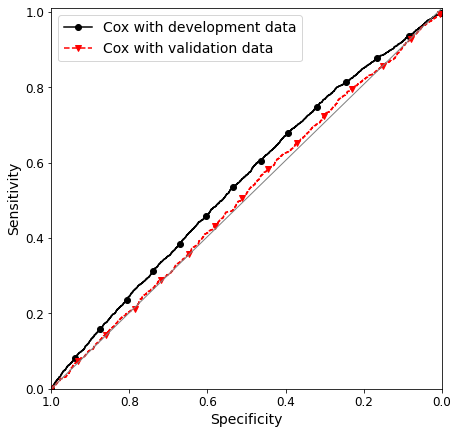

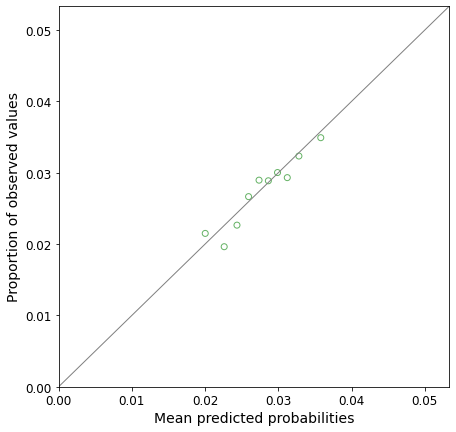

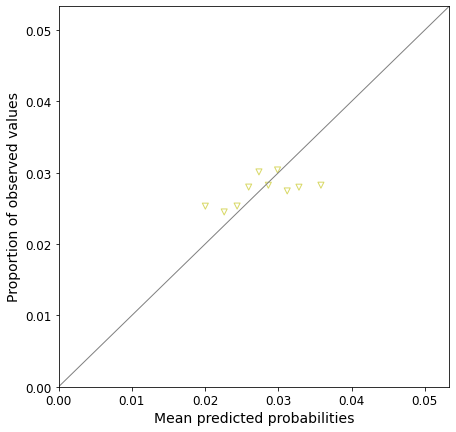

In [133]:
#data prep
data, data_cough_cold_no_abs_incdt_enc = cox_data_prep(data_cough_cold_no_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

#make summary table
make_summary_table('cough_cold', 'no_abs_incdt', data_cough_cold_no_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('cough_cold', 'no_abs_incdt', data_cough_cold_no_abs_incdt)

try:
    #build cox model 
    cph_cough_cold_no_abs_incdt, data_cough_cold_no_abs_incdt_train, data_cough_cold_no_abs_incdt_test = cox_model_build('cough_cold', 'no_abs_incdt', data_cough_cold_no_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_cough_cold_no_abs_incdt, '../output/hospitalisation_prediction_cough_cold/', 'betas_cph_cough_cold_no_abs_incdt.csv', data_cough_cold_no_abs_incdt_enc, data_cough_cold_no_abs_incdt, 'sum_betas_cph_cough_cold_no_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_cough_cold_no_abs_incdt, 'event_cough_cold_admitted', data_cough_cold_no_abs_incdt_train, data_cough_cold_no_abs_incdt_test, '../output/hospitalisation_prediction_cough_cold', 'roc_cph_cough_cold_no_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_cough_cold_no_abs_incdt, data_cough_cold_no_abs_incdt_train, 'event_cough_cold_admitted', data_cough_cold_no_abs_incdt_test, '../output/hospitalisation_prediction_cough_cold/', 'calibration_cph_cough_cold_no_abs_incdt_train.jpg', 'calibration_cph_cough_cold_no_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_cough_cold_no_abs_incdt, 'cough_cold', 'no_abs_incdt', data_cough_cold_no_abs_incdt_train, data_cough_cold_no_abs_incdt_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-2- incident cough_cold with antibiotics

<lifelines.CoxPHFitter: fitted with 12560 total observations, 12221 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 12560
number of events observed = 339
   partial log-likelihood = -3167.44
         time fit was run = 2022-11-24 01:22:50 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.16       1.17       0.17            -0.17             0.49                 0.85                 1.63
CCI_cat[T.medium]                0.19       1.21       0.18            -0.17             0.55                 0.85                 1.74
CCI_cat[T.high]                  0.34       1.40       0.21            -0.07             0.75                 0.94                 2.11
CCI_cat[T.very_high]             0.28       1.33       0.19            -0.08             0.65                 0.92                 1.92
age_cat[T.25_34]                 0.37       1.45       0.20            -0.02             0.77                 0.98                 2.16
age_cat[T.35_44]                 0.32       1.38       0.21            -0.08             0.73                 0.92                 2.07
age_cat[T.45_54]                 0.24       1.27       0.21            -0.18             0.65                 0.84                 1.91
age_cat[T.55_64]                 0.41       1.51       0.20             0.01             0.81                 1.01                 2.24
age_cat[T.65_74]                -0.11       0.89       0.23            -0.56             0.34                 0.57                 1.40
age_cat[T.75_more]              -0.17       0.85       0.23            -0.62             0.29                 0.54                 1.34
antibacterial_brit              -0.02       0.98       0.04            -0.10             0.05                 0.91                 1.05
bmi_cat[T.obese]                -0.07       0.93       0.20            -0.46             0.32                 0.63                 1.38
bmi_cat[T.overweight]           -0.19       0.82       0.25            -0.69             0.31                 0.50                 1.36
bmi_cat[T.underweight]          -0.42       0.65       0.40            -1.21             0.36                 0.30                 1.43
bmi_cat[T.unknown]              -0.04       0.96       0.21            -0.46             0.38                 0.63                 1.46
ethnicity[T.unknown]             0.08       1.08       0.18            -0.27             0.42                 0.76                 1.53
ethnicity[T.white]              -0.01       0.99       0.16            -0.32             0.30                 0.73                 1.36
flu_vaccine[T.yes]               0.01       1.01       0.18            -0.34             0.37                 0.71                 1.45
imd[T.medium]                   -0.32       0.73       0.18            -0.67             0.03                 0.51                 1.03
imd[T.unaffluent]               -0.08       0.93       0.17            -0.40             0.25                 0.67                 1.29
imd[T.unknown]                   0.03       1.03       0.26            -0.48             0.53                 0.62                 1.70
imd[T.very_affluent]            -0.11       0.90       0.17            -0.44             0.22                 0.64                 1.25
imd[T.very_unaffluent]          -0.33       0.72       0.18            -0.67             0.02                 0.51                 1.02
region[T.east_midlands]         -0.43       0.65       0.24            -0.90             0.05                 0.40                 1.06
region[T.london]                -0.35       0.71       0

12798


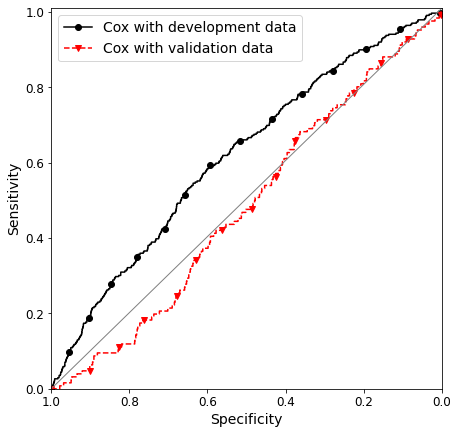

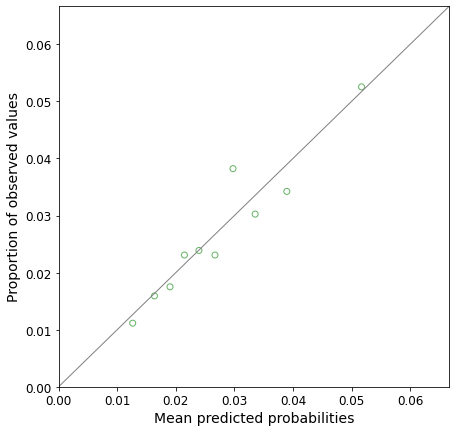

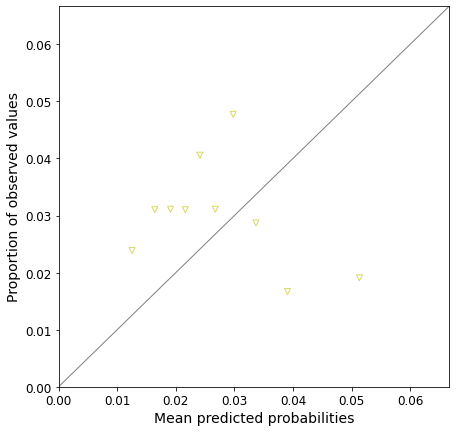

In [134]:
#data prep
data, data_cough_cold_abs_incdt_enc = cox_data_prep(data_cough_cold_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

#make summary table
make_summary_table('cough_cold', 'abs_incdt', data_cough_cold_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('cough_cold', 'abs_incdt', data_cough_cold_abs_incdt)

try:
    #build cox model 
    cph_cough_cold_abs_incdt, data_cough_cold_abs_incdt_train, data_cough_cold_abs_incdt_test = cox_model_build('cough_cold', 'abs_incdt', data_cough_cold_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_cough_cold_abs_incdt, '../output/hospitalisation_prediction_cough_cold/', 'betas_cph_cough_cold_abs_incdt.csv', data_cough_cold_abs_incdt_enc, data_cough_cold_abs_incdt, 'sum_betas_cph_cough_cold_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_cough_cold_abs_incdt, 'event_cough_cold_admitted', data_cough_cold_abs_incdt_train, data_cough_cold_abs_incdt_test, '../output/hospitalisation_prediction_cough_cold', 'roc_cph_cough_cold_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_cough_cold_abs_incdt, data_cough_cold_abs_incdt_train, 'event_cough_cold_admitted', data_cough_cold_abs_incdt_test, '../output/hospitalisation_prediction_cough_cold/', 'calibration_cph_cough_cold_abs_incdt_train.jpg', 'calibration_cph_cough_cold_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_cough_cold_abs_incdt, 'cough_cold', 'abs_incdt', data_cough_cold_abs_incdt_train, data_cough_cold_abs_incdt_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-3- prevalent cough_cold with no antibiotics

<lifelines.CoxPHFitter: fitted with 12510 total observations, 12157 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 12510
number of events observed = 353
   partial log-likelihood = -3305.88
         time fit was run = 2022-11-24 01:22:54 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.11       0.89       0.15            -0.40             0.17                 0.67                 1.19
CCI_cat[T.medium]               -0.05       0.95       0.16            -0.37             0.27                 0.69                 1.31
CCI_cat[T.high]                 -0.28       0.76       0.21            -0.69             0.14                 0.50                 1.15
CCI_cat[T.very_high]            -0.32       0.73       0.18            -0.68             0.04                 0.51                 1.04
age_cat[T.25_34]                 0.26       1.30       0.21            -0.15             0.68                 0.86                 1.97
age_cat[T.35_44]                 0.01       1.01       0.22            -0.42             0.45                 0.66                 1.57
age_cat[T.45_54]                 0.29       1.33       0.21            -0.12             0.70                 0.88                 2.01
age_cat[T.55_64]                 0.32       1.37       0.21            -0.09             0.72                 0.91                 2.06
age_cat[T.65_74]                 0.45       1.57       0.20             0.06             0.85                 1.06                 2.33
age_cat[T.75_more]               0.15       1.16       0.22            -0.28             0.57                 0.76                 1.77
antibacterial_brit              -0.02       0.98       0.04            -0.09             0.06                 0.91                 1.06
bmi_cat[T.obese]                 0.21       1.23       0.22            -0.23             0.64                 0.80                 1.90
bmi_cat[T.overweight]            0.17       1.19       0.26            -0.34             0.69                 0.71                 1.99
bmi_cat[T.underweight]           0.32       1.38       0.35            -0.36             1.00                 0.70                 2.73
bmi_cat[T.unknown]               0.23       1.26       0.23            -0.23             0.69                 0.80                 1.99
ethnicity[T.unknown]             0.00       1.00       0.18            -0.35             0.35                 0.71                 1.42
ethnicity[T.white]               0.09       1.09       0.16            -0.22             0.39                 0.80                 1.48
flu_vaccine[T.yes]              -0.24       0.79       0.20            -0.63             0.15                 0.54                 1.16
imd[T.medium]                   -0.16       0.85       0.18            -0.51             0.19                 0.60                 1.22
imd[T.unaffluent]                0.04       1.04       0.17            -0.29             0.37                 0.75                 1.45
imd[T.unknown]                   0.02       1.02       0.26            -0.49             0.53                 0.61                 1.69
imd[T.very_affluent]            -0.05       0.95       0.17            -0.39             0.29                 0.68                 1.33
imd[T.very_unaffluent]           0.05       1.05       0.17            -0.28             0.38                 0.76                 1.46
region[T.east_midlands]          0.17       1.19       0.23            -0.28             0.63                 0.75                 1.88
region[T.london]                 0.02       1.02       0

12775


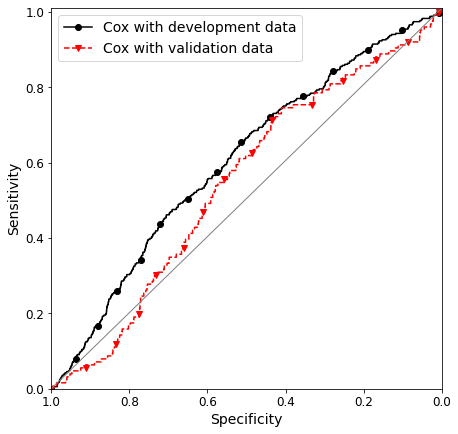

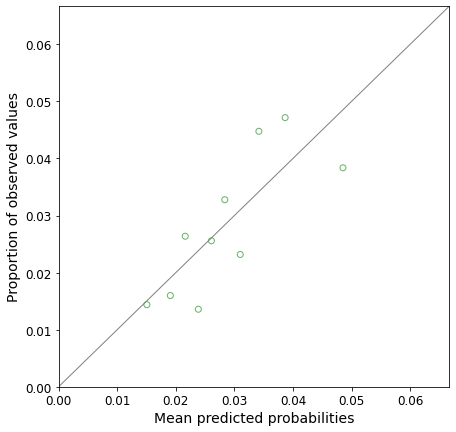

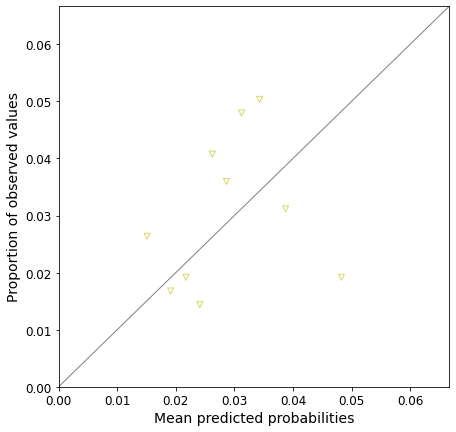

In [135]:
#data prep
data, data_cough_cold_no_abs_prevl_enc = cox_data_prep(data_cough_cold_no_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

#make summary table
make_summary_table('cough_cold', 'no_abs_prevl', data_cough_cold_no_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('cough_cold', 'no_abs_prevl', data_cough_cold_no_abs_prevl)

try:
    #build cox model 
    cph_cough_cold_no_abs_prevl, data_cough_cold_no_abs_prevl_train, data_cough_cold_no_abs_prevl_test = cox_model_build('cough_cold', 'no_abs_prevl', data_cough_cold_no_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:    
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_cough_cold_no_abs_prevl, '../output/hospitalisation_prediction_cough_cold/', 'betas_cph_cough_cold_no_abs_prevl.csv', data_cough_cold_no_abs_prevl_enc, data_cough_cold_no_abs_prevl, 'sum_betas_cph_cough_cold_no_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_cough_cold_no_abs_prevl, 'event_cough_cold_admitted', data_cough_cold_no_abs_prevl_train, data_cough_cold_no_abs_prevl_test, '../output/hospitalisation_prediction_cough_cold', 'roc_cph_cough_cold_no_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_cough_cold_no_abs_prevl, data_cough_cold_no_abs_prevl_train, 'event_cough_cold_admitted', data_cough_cold_no_abs_prevl_test, '../output/hospitalisation_prediction_cough_cold/', 'calibration_cph_cough_cold_no_abs_prevl_train.jpg', 'calibration_cph_cough_cold_no_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_cough_cold_no_abs_prevl, 'cough_cold', 'no_abs_prevl', data_cough_cold_no_abs_prevl_train, data_cough_cold_no_abs_prevl_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-4- prevalent cough_cold with antibiotics

<lifelines.CoxPHFitter: fitted with 1386 total observations, 1357 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 1386
number of events observed = 29
   partial log-likelihood = -191.74
         time fit was run = 2022-11-24 01:22:57 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.47       1.60       0.59            -0.69             1.63                 0.50                 5.12
CCI_cat[T.medium]                0.25       1.28       0.68            -1.09             1.58                 0.34                 4.88
CCI_cat[T.high]                 -0.38       0.68       0.88            -2.11             1.34                 0.12                 3.83
CCI_cat[T.very_high]             0.63       1.88       0.67            -0.68             1.94                 0.51                 6.95
age_cat[T.25_34]                -0.31       0.73       0.92            -2.12             1.50                 0.12                 4.48
age_cat[T.35_44]                 0.65       1.92       0.74            -0.80             2.11                 0.45                 8.21
age_cat[T.45_54]                 0.62       1.86       0.78            -0.90             2.14                 0.41                 8.50
age_cat[T.55_64]                 0.97       2.64       0.69            -0.38             2.32                 0.69                10.14
age_cat[T.65_74]                 0.12       1.13       0.83            -1.51             1.75                 0.22                 5.74
age_cat[T.75_more]               0.38       1.46       0.77            -1.13             1.89                 0.32                 6.60
antibacterial_brit              -0.07       0.94       0.14            -0.33             0.20                 0.72                 1.22
bmi_cat[T.obese]                 0.82       2.26       1.05            -1.24             2.87                 0.29                17.72
bmi_cat[T.overweight]            1.48       4.38       1.12            -0.72             3.67                 0.49                39.38
bmi_cat[T.underweight]           0.92       2.51       1.45            -1.92             3.76                 0.15                43.11
bmi_cat[T.unknown]               0.96       2.60       1.08            -1.16             3.07                 0.31                21.63
ethnicity[T.unknown]            -0.51       0.60       0.58            -1.65             0.62                 0.19                 1.87
ethnicity[T.white]              -0.58       0.56       0.50            -1.56             0.39                 0.21                 1.47
flu_vaccine[T.yes]              -0.87       0.42       0.76            -2.35             0.61                 0.10                 1.84
imd[T.medium]                   -0.92       0.40       0.60            -2.10             0.26                 0.12                 1.30
imd[T.unaffluent]               -0.79       0.46       0.61            -1.98             0.41                 0.14                 1.50
imd[T.unknown]                 -17.40       0.00    3839.28         -7542.24          7507.44                 0.00                  inf
imd[T.very_affluent]            -0.62       0.54       0.53            -1.67             0.42                 0.19                 1.53
imd[T.very_unaffluent]          -0.66       0.52       0.56            -1.76             0.45                 0.17                 1.56
region[T.east_midlands]         -0.02       0.98       0.68            -1.35             1.32                 0.26                 3.74
region[T.london]                -0.87       0.42       0.66  

12807


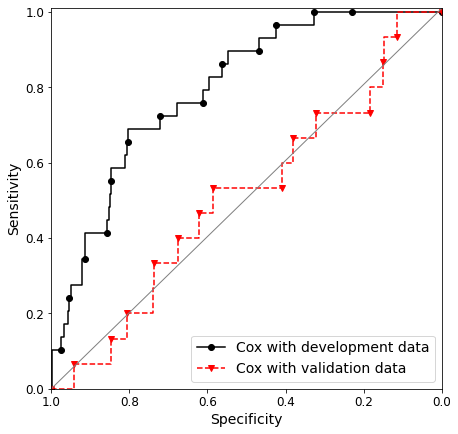

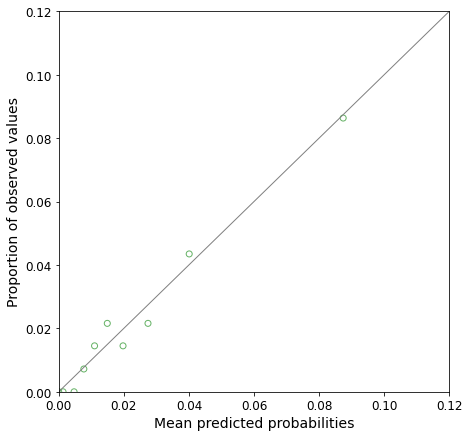

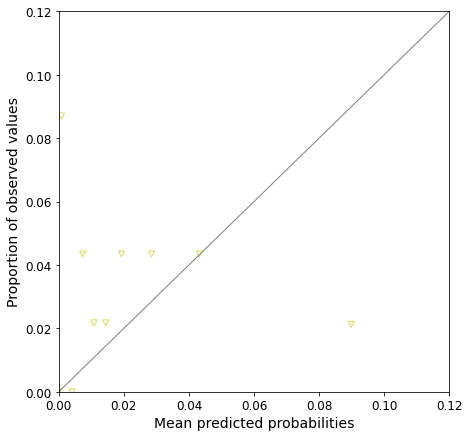

In [136]:
#data prep
data, data_cough_cold_abs_prevl_enc = cox_data_prep(data_cough_cold_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

#make summary table
make_summary_table('cough_cold', 'abs_prevl', data_cough_cold_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('cough_cold', 'abs_prevl', data_cough_cold_abs_prevl)

try:
    #build cox model 
    cph_cough_cold_abs_prevl, data_cough_cold_abs_prevl_train, data_cough_cold_abs_prevl_test = cox_model_build('cough_cold', 'abs_prevl', data_cough_cold_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_cough_cold_abs_prevl, '../output/hospitalisation_prediction_cough_cold/', 'betas_cph_cough_cold_abs_prevl.csv', data_cough_cold_abs_prevl_enc, data_cough_cold_abs_prevl, 'sum_betas_cph_cough_cold_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_cough_cold_abs_prevl, 'event_cough_cold_admitted', data_cough_cold_abs_prevl_train, data_cough_cold_abs_prevl_test, '../output/hospitalisation_prediction_cough_cold', 'roc_cph_cough_cold_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_cough_cold_abs_prevl, data_cough_cold_abs_prevl_train, 'event_cough_cold_admitted', data_cough_cold_abs_prevl_test, '../output/hospitalisation_prediction_cough_cold/', 'calibration_cph_cough_cold_abs_prevl_train.jpg', 'calibration_cph_cough_cold_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_cough_cold_abs_prevl, 'cough_cold', 'abs_prevl', data_cough_cold_abs_prevl_train, data_cough_cold_abs_prevl_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-5- incident cough_cold

In [137]:
#data prep
data, data_cough_cold_incdt_enc = cox_data_prep(data_cough_cold_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

#make summary tables from preped data
make_summary_table('cough_cold', 'incdt', data_cough_cold_incdt_enc)
make_summary_table_hosped('cough_cold', 'incdt', data_cough_cold_incdt)

try:
    cph_cough_cold_incdt, data_cough_cold_incdt_train, data_cough_cold_incdt_test = cox_model_abs_build('cough_cold', 'incdt', data_cough_cold_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_cough_cold_incdt, 'cough_cold', 'incdt', data_cough_cold_incdt_train, data_cough_cold_incdt_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 125113 total observations, 121661 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 125113
number of events observed = 3452
   partial log-likelihood = -40431.72
         time fit was run = 2022-11-24 01:23:02 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.15       0.86       0.05            -0.24            -0.05                 0.78                 0.95
CCI_cat[T.medium]               -0.10       0.90       0.05            -0.21             0.00                 0.81                 1.00
CCI_cat[T.high]                 -0.11       0.89       0.07            -0.24             0.02                 0.79                 1.02
CCI_cat[T.very_high]            -0.13       0.88       0.06            -0.24            -0.01                 0.79                 0.99
age_cat[T.25_34]                 0.01       1.01       0.07            -0.12             0.14                 0.89                 1.15
age_cat[T.35_44]                 0.10       1.10       0.06            -0.03             0.22                 0.97                 1.25
age_cat[T.45_54]                 0.04       1.04       0.06            -0.09             0.16                 0.91                 1.18
age_cat[T.55_64]                 0.08       1.08       0.06            -0.04             0.21                 0.96                 1.23
age_cat[T.65_74]                 0.02       1.02       0.06            -0.11             0.14                 0.90                 1.15
age_cat[T.75_more]               0.06       1.06       0.06            -0.07             0.19                 0.94                 1.21
antibacterial_brit              -0.01       0.99       0.01            -0.03             0.02                 0.97                 1.02
bmi_cat[T.obese]                -0.05       0.95       0.06            -0.17             0.08                 0.84                 1.08
bmi_cat[T.overweight]           -0.12       0.89       0.08            -0.27             0.03                 0.76                 1.03
bmi_cat[T.underweight]          -0.12       0.88       0.11            -0.34             0.10                 0.71                 1.10
bmi_cat[T.unknown]              -0.06       0.94       0.07            -0.20             0.07                 0.82                 1.07
cough_cold_ab_date               0.02       1.02       0.06            -0.09             0.13                 0.91                 1.14
ethnicity[T.unknown]             0.04       1.04       0.06            -0.07             0.15                 0.93                 1.16
ethnicity[T.white]               0.04       1.05       0.05            -0.05             0.14                 0.95                 1.15
flu_vaccine[T.yes]              -0.02       0.98       0.06            -0.13             0.10                 0.88                 1.10
imd[T.medium]                    0.09       1.09       0.06            -0.02             0.19                 0.98                 1.21
imd[T.unaffluent]                0.07       1.07       0.06            -0.04             0.18                 0.96                 1.19
imd[T.unknown]                   0.07       1.08       0.08            -0.09             0.24                 0.91                 1.27
imd[T.very_affluent]            -0.03       0.97       0.06            -0.14             0.08                 0.87                 1.09
imd[T.very_unaffluent]           0.03       1.03       0.06            -0.08             0.14                 0.92                 1.15
region[T.east_midlands]         -0.00       1.00   

13078


### 5-6- hospital admission related to prevalent cough_cold

In [138]:
#data prep
data, data_cough_cold_prevl_enc = cox_data_prep(data_cough_cold_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

#make summary tables from preped data
make_summary_table('cough_cold', 'prevl', data_cough_cold_prevl_enc)
make_summary_table_hosped('cough_cold', 'prevl', data_cough_cold_prevl)

try:
    cph_cough_cold_prevl, data_cough_cold_prevl_train, data_cough_cold_prevl_test = cox_model_abs_build('cough_cold', 'prevl', data_cough_cold_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_cough_cold_prevl, 'cough_cold', 'prevl', data_cough_cold_prevl_train, data_cough_cold_prevl_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 13896 total observations, 13495 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 13896
number of events observed = 401
   partial log-likelihood = -3798.46
         time fit was run = 2022-11-24 01:23:09 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.19       1.21       0.15            -0.09             0.48                 0.91                 1.61
CCI_cat[T.medium]                0.14       1.15       0.16            -0.18             0.46                 0.83                 1.59
CCI_cat[T.high]                  0.12       1.13       0.20            -0.26             0.51                 0.77                 1.66
CCI_cat[T.very_high]            -0.11       0.90       0.18            -0.47             0.25                 0.63                 1.28
age_cat[T.25_34]                 0.33       1.39       0.20            -0.07             0.73                 0.93                 2.07
age_cat[T.35_44]                 0.05       1.05       0.22            -0.38             0.47                 0.69                 1.60
age_cat[T.45_54]                 0.32       1.38       0.20            -0.08             0.72                 0.93                 2.05
age_cat[T.55_64]                 0.46       1.59       0.20             0.08             0.85                 1.08                 2.33
age_cat[T.65_74]                 0.54       1.72       0.19             0.16             0.92                 1.18                 2.51
age_cat[T.75_more]               0.37       1.45       0.20            -0.02             0.77                 0.98                 2.15
antibacterial_brit              -0.03       0.97       0.04            -0.10             0.04                 0.91                 1.04
bmi_cat[T.obese]                 0.30       1.34       0.22            -0.13             0.72                 0.88                 2.05
bmi_cat[T.overweight]            0.35       1.41       0.25            -0.15             0.84                 0.86                 2.32
bmi_cat[T.underweight]           0.16       1.17       0.36            -0.56             0.87                 0.57                 2.39
bmi_cat[T.unknown]               0.43       1.53       0.22            -0.02             0.87                 0.98                 2.38
cough_cold_ab_date              -0.22       0.81       0.18            -0.57             0.14                 0.56                 1.15
ethnicity[T.unknown]             0.10       1.10       0.17            -0.24             0.43                 0.79                 1.54
ethnicity[T.white]               0.18       1.20       0.15            -0.12             0.48                 0.89                 1.61
flu_vaccine[T.yes]              -0.16       0.85       0.18            -0.51             0.18                 0.60                 1.20
imd[T.medium]                   -0.25       0.78       0.16            -0.57             0.07                 0.56                 1.07
imd[T.unaffluent]               -0.19       0.82       0.16            -0.50             0.12                 0.60                 1.12
imd[T.unknown]                  -0.01       0.99       0.23            -0.47             0.45                 0.63                 1.57
imd[T.very_affluent]            -0.20       0.82       0.16            -0.51             0.11                 0.60                 1.12
imd[T.very_unaffluent]          -0.08       0.92       0.15            -0.38             0.22                 0.68                 1.25
region[T.east_midlands]          0.09       1.09       0

13049


### 5-7- hospital admission related to incident cough_cold with prescribed antibiotics categories

In [139]:
#data prep
data, data_cough_cold_incdt_abs_enc = cox_data_prep(data_cough_cold_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_incdt_abs, data_cough_cold_incdt_abs_train, data_cough_cold_incdt_abs_test = cox_model_ab_type_build('cough_cold', 'incdt_ab_type', data_cough_cold_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_cough_cold_incdt_abs, 'cough_cold', 'incdt_abs', data_cough_cold_incdt_abs_train, data_cough_cold_incdt_abs_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 125113 total observations, 121661 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 125113
number of events observed = 3452
   partial log-likelihood = -40431.40
         time fit was run = 2022-11-24 01:23:12 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.15       0.86       0.05            -0.24            -0.05                 0.78                 0.95
CCI_cat[T.medium]               -0.10       0.90       0.05            -0.21             0.00                 0.81                 1.00
CCI_cat[T.high]                 -0.11       0.89       0.07            -0.24             0.02                 0.79                 1.02
CCI_cat[T.very_high]            -0.13       0.88       0.06            -0.24            -0.01                 0.79                 0.99
ab_type_cat[T.Doxycycline]       0.29       1.33       0.42            -0.54             1.11                 0.58                 3.04
ab_type_cat[T.no]                0.14       1.15       0.23            -0.31             0.59                 0.73                 1.80
ab_type_cat[T.other]             0.17       1.18       0.24            -0.30             0.63                 0.74                 1.87
age_cat[T.25_34]                 0.01       1.01       0.07            -0.12             0.14                 0.89                 1.15
age_cat[T.35_44]                 0.10       1.10       0.06            -0.03             0.22                 0.97                 1.25
age_cat[T.45_54]                 0.04       1.04       0.06            -0.09             0.16                 0.91                 1.18
age_cat[T.55_64]                 0.08       1.08       0.06            -0.04             0.21                 0.96                 1.23
age_cat[T.65_74]                 0.02       1.02       0.06            -0.11             0.14                 0.90                 1.15
age_cat[T.75_more]               0.06       1.06       0.06            -0.07             0.19                 0.94                 1.21
antibacterial_brit              -0.01       0.99       0.01            -0.03             0.02                 0.97                 1.02
bmi_cat[T.obese]                -0.05       0.95       0.06            -0.17             0.08                 0.84                 1.08
bmi_cat[T.overweight]           -0.12       0.89       0.08            -0.27             0.03                 0.76                 1.03
bmi_cat[T.underweight]          -0.12       0.88       0.11            -0.34             0.10                 0.71                 1.10
bmi_cat[T.unknown]              -0.06       0.94       0.07            -0.20             0.07                 0.82                 1.07
ethnicity[T.unknown]             0.04       1.04       0.06            -0.07             0.15                 0.93                 1.16
ethnicity[T.white]               0.04       1.05       0.05            -0.05             0.14                 0.95                 1.15
flu_vaccine[T.yes]              -0.02       0.98       0.06            -0.13             0.10                 0.88                 1.10
imd[T.medium]                    0.09       1.09       0.06            -0.02             0.19                 0.98                 1.21
imd[T.unaffluent]                0.07       1.07       0.06            -0.04             0.18                 0.96                 1.19
imd[T.unknown]                   0.07       1.08       0.08            -0.09             0.24                 0.91                 1.27
imd[T.very_affluent]            -0.03       0.97   

13634


### 5-8- hospital admission related to prevalent cough_cold with prescribed antibiotics categories

In [140]:
#data prep
data, data_cough_cold_prevl_abs_enc = cox_data_prep(data_cough_cold_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_prevl_abs, data_cough_cold_prevl_abs_train, data_cough_cold_prevl_abs_test = cox_model_ab_type_build('cough_cold', 'prevl_ab_type', data_cough_cold_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_cough_cold_prevl_abs, 'cough_cold', 'prevl_abs', data_cough_cold_prevl_abs_train, data_cough_cold_prevl_abs_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 13896 total observations, 13495 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 13896
number of events observed = 401
   partial log-likelihood = -3797.52
         time fit was run = 2022-11-24 01:23:18 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.19       1.21       0.15            -0.09             0.48                 0.91                 1.61
CCI_cat[T.medium]                0.14       1.15       0.16            -0.18             0.46                 0.83                 1.59
CCI_cat[T.high]                  0.12       1.13       0.20            -0.26             0.51                 0.77                 1.66
CCI_cat[T.very_high]            -0.11       0.90       0.18            -0.46             0.25                 0.63                 1.28
ab_type_cat[T.Doxycycline]     -13.00       0.00    1073.43         -2116.88          2090.87                 0.00                  inf
ab_type_cat[T.no]                0.80       2.23       1.00            -1.16             2.77                 0.31                15.90
ab_type_cat[T.other]             0.64       1.89       1.02            -1.36             2.63                 0.26                13.84
age_cat[T.25_34]                 0.33       1.39       0.20            -0.07             0.73                 0.93                 2.07
age_cat[T.35_44]                 0.05       1.05       0.22            -0.38             0.47                 0.69                 1.60
age_cat[T.45_54]                 0.32       1.38       0.20            -0.08             0.72                 0.93                 2.05
age_cat[T.55_64]                 0.46       1.58       0.20             0.07             0.85                 1.08                 2.33
age_cat[T.65_74]                 0.55       1.73       0.19             0.17             0.92                 1.18                 2.52
age_cat[T.75_more]               0.37       1.45       0.20            -0.02             0.77                 0.98                 2.16
antibacterial_brit              -0.03       0.97       0.04            -0.10             0.04                 0.91                 1.04
bmi_cat[T.obese]                 0.29       1.34       0.22            -0.13             0.72                 0.88                 2.05
bmi_cat[T.overweight]            0.34       1.41       0.25            -0.15             0.84                 0.86                 2.32
bmi_cat[T.underweight]           0.16       1.17       0.36            -0.56             0.87                 0.57                 2.39
bmi_cat[T.unknown]               0.42       1.53       0.22            -0.02             0.87                 0.98                 2.38
ethnicity[T.unknown]             0.10       1.10       0.17            -0.24             0.43                 0.79                 1.54
ethnicity[T.white]               0.18       1.20       0.15            -0.12             0.48                 0.89                 1.61
flu_vaccine[T.yes]              -0.16       0.85       0.18            -0.51             0.18                 0.60                 1.20
imd[T.medium]                   -0.26       0.77       0.16            -0.58             0.06                 0.56                 1.07
imd[T.unaffluent]               -0.19       0.82       0.16            -0.50             0.12                 0.60                 1.13
imd[T.unknown]                  -0.00       1.00       0.23            -0.46             0.46                 0.63                 1.58
imd[T.very_affluent]            -0.20       0.82       0

13622


### 5-9- stratified by sex
#### 5-9-1- incident males

In [141]:
#data prep
data, data_cough_cold_incdt_males_enc = cox_data_prep(data_cough_cold_incdt_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_incdt_males, data_cough_cold_incdt_males_train, data_cough_cold_incdt_males_test = cox_model_strat_sex_build('cough_cold', 'incdt_males', data_cough_cold_incdt_males)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_cough_cold_incdt_males, 'cough_cold', 'incdt_males', data_cough_cold_incdt_males_train, data_cough_cold_incdt_males_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 61075 total observations, 59413 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 61075
number of events observed = 1662
   partial log-likelihood = -18260.68
         time fit was run = 2022-11-24 01:23:21 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.11       0.89       0.07            -0.25             0.02                 0.78                 1.02
CCI_cat[T.medium]               -0.12       0.88       0.08            -0.27             0.03                 0.76                 1.03
CCI_cat[T.high]                 -0.23       0.79       0.10            -0.42            -0.04                 0.66                 0.96
CCI_cat[T.very_high]            -0.16       0.85       0.08            -0.33            -0.00                 0.72                 1.00
age_cat[T.25_34]                -0.01       0.99       0.10            -0.20             0.18                 0.82                 1.20
age_cat[T.35_44]                 0.13       1.14       0.09            -0.05             0.32                 0.95                 1.37
age_cat[T.45_54]                 0.06       1.07       0.10            -0.12             0.25                 0.89                 1.29
age_cat[T.55_64]                 0.17       1.19       0.09            -0.01             0.36                 0.99                 1.43
age_cat[T.65_74]                 0.10       1.11       0.09            -0.08             0.29                 0.92                 1.33
age_cat[T.75_more]               0.15       1.16       0.09            -0.03             0.33                 0.97                 1.39
antibacterial_brit               0.00       1.00       0.02            -0.03             0.04                 0.97                 1.04
bmi_cat[T.obese]                 0.05       1.05       0.09            -0.14             0.23                 0.87                 1.26
bmi_cat[T.overweight]            0.05       1.05       0.11            -0.17             0.27                 0.84                 1.32
bmi_cat[T.underweight]           0.09       1.09       0.16            -0.22             0.40                 0.80                 1.49
bmi_cat[T.unknown]               0.01       1.01       0.10            -0.19             0.20                 0.83                 1.23
cough_cold_ab_date              -0.08       0.92       0.08            -0.25             0.08                 0.78                 1.09
ethnicity[T.unknown]            -0.01       0.99       0.08            -0.17             0.15                 0.85                 1.17
ethnicity[T.white]               0.06       1.06       0.07            -0.08             0.20                 0.92                 1.22
flu_vaccine[T.yes]              -0.10       0.91       0.08            -0.27             0.07                 0.77                 1.07
imd[T.medium]                   -0.01       0.99       0.08            -0.17             0.15                 0.84                 1.16
imd[T.unaffluent]                0.08       1.09       0.08            -0.07             0.24                 0.93                 1.27
imd[T.unknown]                   0.17       1.19       0.12            -0.06             0.40                 0.94                 1.50
imd[T.very_affluent]             0.06       1.06       0.08            -0.09             0.22                 0.91                 1.24
imd[T.very_unaffluent]           0.00       1.00       0.08            -0.15             0.16                 0.86                 1.18
region[T.east_midlands]         -0.05       0.95      

12809


#### 5-9-2- incident females

In [142]:
#data prep
data, data_cough_cold_incdt_females_enc = cox_data_prep(data_cough_cold_incdt_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_incdt_females, data_cough_cold_incdt_females_train, data_cough_cold_incdt_females_test = cox_model_strat_sex_build('cough_cold', 'incdt_females', data_cough_cold_incdt_females)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_cough_cold_incdt_females, 'cough_cold', 'incdt_females', data_cough_cold_incdt_females_train, data_cough_cold_incdt_females_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 64038 total observations, 62261 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 64038
number of events observed = 1777
   partial log-likelihood = -19617.58
         time fit was run = 2022-11-24 01:23:24 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.12       0.89       0.07            -0.25             0.01                 0.78                 1.01
CCI_cat[T.medium]               -0.06       0.94       0.07            -0.21             0.09                 0.81                 1.09
CCI_cat[T.high]                 -0.10       0.90       0.09            -0.28             0.08                 0.75                 1.08
CCI_cat[T.very_high]            -0.03       0.97       0.08            -0.19             0.12                 0.83                 1.13
age_cat[T.25_34]                -0.01       0.99       0.09            -0.18             0.17                 0.83                 1.18
age_cat[T.35_44]                 0.07       1.07       0.09            -0.10             0.24                 0.90                 1.27
age_cat[T.45_54]                 0.02       1.02       0.09            -0.15             0.19                 0.86                 1.21
age_cat[T.55_64]                 0.01       1.01       0.09            -0.16             0.18                 0.85                 1.20
age_cat[T.65_74]                -0.15       0.86       0.09            -0.33             0.03                 0.72                 1.03
age_cat[T.75_more]              -0.04       0.96       0.09            -0.21             0.14                 0.81                 1.15
antibacterial_brit              -0.01       0.99       0.02            -0.04             0.02                 0.96                 1.02
bmi_cat[T.obese]                -0.02       0.98       0.09            -0.19             0.15                 0.83                 1.17
bmi_cat[T.overweight]           -0.04       0.96       0.11            -0.25             0.17                 0.78                 1.19
bmi_cat[T.underweight]          -0.14       0.87       0.16            -0.45             0.17                 0.64                 1.18
bmi_cat[T.unknown]              -0.03       0.97       0.09            -0.21             0.16                 0.81                 1.17
cough_cold_ab_date               0.04       1.04       0.08            -0.11             0.19                 0.89                 1.21
ethnicity[T.unknown]             0.07       1.07       0.08            -0.09             0.22                 0.92                 1.24
ethnicity[T.white]               0.05       1.05       0.07            -0.08             0.19                 0.92                 1.21
flu_vaccine[T.yes]               0.02       1.02       0.08            -0.14             0.17                 0.87                 1.19
imd[T.medium]                    0.15       1.17       0.08             0.00             0.31                 1.00                 1.36
imd[T.unaffluent]                0.10       1.11       0.08            -0.05             0.25                 0.95                 1.29
imd[T.unknown]                   0.19       1.21       0.12            -0.04             0.42                 0.96                 1.52
imd[T.very_affluent]             0.11       1.11       0.08            -0.05             0.26                 0.95                 1.30
imd[T.very_unaffluent]           0.07       1.07       0.08            -0.09             0.22                 0.92                 1.25
region[T.east_midlands]         -0.13       0.88      

12798


#### 5-9-3- prevalent males

In [143]:
#data prep
data, data_cough_cold_prevl_males_enc = cox_data_prep(data_cough_cold_prevl_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_prevl_males, data_cough_cold_prevl_males_train, data_cough_cold_prevl_males_test = cox_model_strat_sex_build('cough_cold', 'prevl_males', data_cough_cold_prevl_males)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:  
    # calculate c-statistics
    cph_output(cph_cough_cold_prevl_males, 'cough_cold', 'prevl_males', data_cough_cold_prevl_males_train, data_cough_cold_prevl_males_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 6817 total observations, 6607 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 6817
number of events observed = 210
   partial log-likelihood = -1834.15
         time fit was run = 2022-11-24 01:23:28 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.07       0.94       0.19            -0.44             0.31                 0.65                 1.36
CCI_cat[T.medium]               -0.19       0.83       0.22            -0.63             0.25                 0.53                 1.28
CCI_cat[T.high]                 -0.26       0.77       0.27            -0.79             0.27                 0.46                 1.32
CCI_cat[T.very_high]            -0.22       0.80       0.24            -0.68             0.24                 0.51                 1.28
age_cat[T.25_34]                 0.09       1.09       0.27            -0.45             0.62                 0.64                 1.87
age_cat[T.35_44]                 0.32       1.37       0.26            -0.19             0.82                 0.83                 2.27
age_cat[T.45_54]                 0.25       1.28       0.26            -0.26             0.76                 0.77                 2.14
age_cat[T.55_64]                -0.02       0.98       0.28            -0.56             0.52                 0.57                 1.69
age_cat[T.65_74]                 0.27       1.32       0.26            -0.23             0.78                 0.79                 2.18
age_cat[T.75_more]               0.11       1.12       0.27            -0.42             0.64                 0.66                 1.89
antibacterial_brit              -0.08       0.93       0.05            -0.17             0.02                 0.84                 1.02
bmi_cat[T.obese]                 0.68       1.97       0.35             0.00             1.36                 1.00                 3.89
bmi_cat[T.overweight]            0.64       1.90       0.39            -0.12             1.40                 0.88                 4.07
bmi_cat[T.underweight]           0.60       1.81       0.51            -0.39             1.59                 0.67                 4.88
bmi_cat[T.unknown]               0.56       1.76       0.36            -0.15             1.28                 0.86                 3.58
cough_cold_ab_date              -0.19       0.83       0.25            -0.68             0.31                 0.51                 1.37
ethnicity[T.unknown]            -0.12       0.89       0.22            -0.55             0.30                 0.58                 1.36
ethnicity[T.white]              -0.17       0.84       0.19            -0.54             0.20                 0.58                 1.23
flu_vaccine[T.yes]              -0.65       0.52       0.31            -1.26            -0.04                 0.28                 0.96
imd[T.medium]                   -0.36       0.70       0.24            -0.83             0.11                 0.44                 1.11
imd[T.unaffluent]                0.07       1.07       0.21            -0.34             0.48                 0.71                 1.62
imd[T.unknown]                   0.06       1.06       0.33            -0.58             0.70                 0.56                 2.01
imd[T.very_affluent]            -0.03       0.97       0.22            -0.46             0.39                 0.63                 1.48
imd[T.very_unaffluent]          -0.18       0.83       0.22            -0.62             0.26                 0.54                 1.29
region[T.east_midlands]          0.47       1.59       0.29

12790


#### 5-9-4- prevalent females

In [144]:
try:
    #data prep
    data, data_cough_cold_prevl_females_enc = cox_data_prep(data_cough_cold_prevl_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

    #cox model
    cph_cough_cold_prevl_females, data_cough_cold_prevl_females_train, data_cough_cold_prevl_females_test = cox_model_strat_sex_build('cough_cold', 'prevl_females', data_cough_cold_prevl_females)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_cough_cold_prevl_females, 'cough_cold', 'prevl_females', data_cough_cold_prevl_females_train, data_cough_cold_prevl_females_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 7078 total observations, 6899 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 7078
number of events observed = 179
   partial log-likelihood = -1564.89
         time fit was run = 2022-11-24 01:23:29 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.09       0.91       0.22            -0.51             0.33                 0.60                 1.40
CCI_cat[T.medium]                0.14       1.15       0.23            -0.31             0.60                 0.73                 1.82
CCI_cat[T.high]                  0.08       1.08       0.28            -0.48             0.63                 0.62                 1.88
CCI_cat[T.very_high]            -0.16       0.85       0.26            -0.68             0.35                 0.51                 1.42
age_cat[T.25_34]                 0.23       1.26       0.30            -0.35             0.82                 0.70                 2.27
age_cat[T.35_44]                -0.01       0.99       0.31            -0.62             0.61                 0.54                 1.84
age_cat[T.45_54]                 0.24       1.27       0.30            -0.35             0.83                 0.71                 2.30
age_cat[T.55_64]                 0.52       1.68       0.28            -0.03             1.07                 0.97                 2.93
age_cat[T.65_74]                 0.38       1.47       0.29            -0.18             0.94                 0.84                 2.57
age_cat[T.75_more]               0.07       1.07       0.32            -0.55             0.69                 0.57                 1.99
antibacterial_brit               0.10       1.10       0.05             0.00             0.20                 1.00                 1.22
bmi_cat[T.obese]                 0.02       1.02       0.30            -0.57             0.60                 0.57                 1.83
bmi_cat[T.overweight]            0.22       1.24       0.35            -0.48             0.91                 0.62                 2.48
bmi_cat[T.underweight]           0.60       1.82       0.44            -0.25             1.46                 0.78                 4.29
bmi_cat[T.unknown]               0.25       1.28       0.31            -0.36             0.86                 0.70                 2.36
cough_cold_ab_date              -0.05       0.96       0.26            -0.55             0.46                 0.58                 1.58
ethnicity[T.unknown]             0.28       1.32       0.27            -0.24             0.80                 0.79                 2.22
ethnicity[T.white]               0.28       1.33       0.24            -0.19             0.75                 0.83                 2.11
flu_vaccine[T.yes]               0.03       1.03       0.24            -0.45             0.51                 0.64                 1.66
imd[T.medium]                   -0.01       0.99       0.24            -0.47             0.46                 0.62                 1.58
imd[T.unaffluent]               -0.19       0.83       0.25            -0.68             0.30                 0.51                 1.35
imd[T.unknown]                   0.32       1.38       0.32            -0.30             0.94                 0.74                 2.56
imd[T.very_affluent]            -0.58       0.56       0.28            -1.13            -0.04                 0.32                 0.96
imd[T.very_unaffluent]           0.25       1.29       0.22            -0.18             0.69                 0.83                 2.00
region[T.east_midlands]         -0.13       0.88       0.31

12792


### 5-10- stratified by age category
#### 5-10-1- incident

In [145]:
#data prep
data, data_cough_cold_incdt_15_24_enc = cox_data_prep(data_cough_cold_incdt_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_incdt_15_24, data_cough_cold_incdt_15_24_train, data_cough_cold_incdt_15_24_test = cox_model_strat_age_build('cough_cold', 'incdt_15_24', data_cough_cold_incdt_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_cough_cold_incdt_15_24, 'cough_cold', 'incdt_15_24', data_cough_cold_incdt_15_24_train, data_cough_cold_incdt_15_24_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17714 total observations, 17239 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 17714
number of events observed = 475
   partial log-likelihood = -4615.31
         time fit was run = 2022-11-24 01:23:30 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.04       0.96       0.13            -0.28             0.21                 0.75                 1.23
CCI_cat[T.medium]               -0.32       0.72       0.15            -0.62            -0.02                 0.54                 0.98
CCI_cat[T.high]                 -0.25       0.78       0.18            -0.62             0.11                 0.54                 1.11
CCI_cat[T.very_high]            -0.11       0.90       0.15            -0.41             0.19                 0.67                 1.21
antibacterial_brit               0.03       1.03       0.03            -0.04             0.09                 0.96                 1.09
bmi_cat[T.obese]                 0.09       1.10       0.17            -0.24             0.43                 0.78                 1.54
bmi_cat[T.overweight]           -0.04       0.96       0.22            -0.46             0.38                 0.63                 1.47
bmi_cat[T.underweight]          -0.20       0.82       0.33            -0.85             0.45                 0.43                 1.57
bmi_cat[T.unknown]              -0.00       1.00       0.18            -0.37             0.36                 0.69                 1.43
cough_cold_ab_date              -0.11       0.89       0.16            -0.42             0.20                 0.66                 1.22
ethnicity[T.unknown]             0.19       1.21       0.16            -0.12             0.50                 0.89                 1.64
ethnicity[T.white]               0.16       1.17       0.14            -0.12             0.44                 0.89                 1.55
flu_vaccine[T.yes]              -0.17       0.85       0.17            -0.49             0.16                 0.61                 1.18
imd[T.medium]                    0.01       1.01       0.15            -0.29             0.32                 0.75                 1.37
imd[T.unaffluent]                0.13       1.14       0.15            -0.16             0.42                 0.85                 1.52
imd[T.unknown]                   0.17       1.19       0.22            -0.26             0.61                 0.77                 1.83
imd[T.very_affluent]             0.03       1.03       0.15            -0.26             0.33                 0.77                 1.39
imd[T.very_unaffluent]           0.08       1.08       0.15            -0.22             0.37                 0.81                 1.45
region[T.east_midlands]          0.03       1.04       0.21            -0.37             0.44                 0.69                 1.55
region[T.london]                 0.08       1.09       0.18            -0.26             0.43                 0.77                 1.54
region[T.north_east]            -0.24       0.79       0.22            -0.67             0.19                 0.51                 1.21
region[T.north_west]            -0.02       0.98       0.21            -0.44             0.39                 0.65                 1.47
region[T.south_east]             0.15       1.16       0.20            -0.25             0.54                 0.78                 1.71
region[T.south_west]            -0.18       0.84       0.22            -0.61             0.25                 0.55                 1.28
region[T.west_midlands]          0.11       1.11       0

11420


In [146]:
#data prep
data, data_cough_cold_incdt_25_34_enc = cox_data_prep(data_cough_cold_incdt_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_incdt_25_34, data_cough_cold_incdt_25_34_train, data_cough_cold_incdt_25_34_test = cox_model_strat_age_build('cough_cold', 'incdt_25_34', data_cough_cold_incdt_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_cough_cold_incdt_25_34, 'cough_cold', 'incdt_25_34', data_cough_cold_incdt_25_34_train, data_cough_cold_incdt_25_34_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17648 total observations, 17197 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 17648
number of events observed = 451
   partial log-likelihood = -4381.85
         time fit was run = 2022-11-24 01:23:31 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.09       1.10       0.15            -0.20             0.38                 0.82                 1.46
CCI_cat[T.medium]                0.28       1.32       0.16            -0.03             0.59                 0.97                 1.80
CCI_cat[T.high]                  0.41       1.50       0.18             0.06             0.76                 1.06                 2.13
CCI_cat[T.very_high]             0.20       1.23       0.17            -0.12             0.53                 0.88                 1.70
antibacterial_brit              -0.03       0.97       0.03            -0.10             0.03                 0.91                 1.03
bmi_cat[T.obese]                -0.03       0.97       0.18            -0.38             0.32                 0.68                 1.37
bmi_cat[T.overweight]            0.02       1.02       0.22            -0.40             0.44                 0.67                 1.56
bmi_cat[T.underweight]          -0.00       1.00       0.30            -0.59             0.59                 0.56                 1.80
bmi_cat[T.unknown]              -0.06       0.94       0.19            -0.43             0.31                 0.65                 1.36
cough_cold_ab_date               0.22       1.25       0.14            -0.05             0.50                 0.95                 1.65
ethnicity[T.unknown]            -0.02       0.98       0.15            -0.31             0.27                 0.73                 1.31
ethnicity[T.white]              -0.07       0.93       0.13            -0.33             0.19                 0.72                 1.20
flu_vaccine[T.yes]              -0.14       0.87       0.17            -0.46             0.19                 0.63                 1.21
imd[T.medium]                    0.13       1.14       0.15            -0.15             0.42                 0.86                 1.52
imd[T.unaffluent]               -0.02       0.98       0.15            -0.31             0.27                 0.73                 1.31
imd[T.unknown]                  -0.22       0.80       0.26            -0.73             0.28                 0.48                 1.33
imd[T.very_affluent]            -0.00       1.00       0.15            -0.30             0.29                 0.74                 1.34
imd[T.very_unaffluent]          -0.27       0.77       0.16            -0.58             0.05                 0.56                 1.05
region[T.east_midlands]         -0.22       0.80       0.23            -0.68             0.24                 0.51                 1.27
region[T.london]                 0.23       1.26       0.19            -0.13             0.60                 0.88                 1.82
region[T.north_east]             0.03       1.03       0.22            -0.40             0.47                 0.67                 1.60
region[T.north_west]             0.03       1.03       0.21            -0.39             0.45                 0.68                 1.57
region[T.south_east]             0.17       1.19       0.21            -0.24             0.59                 0.78                 1.80
region[T.south_west]             0.15       1.16       0.21            -0.27             0.56                 0.76                 1.76
region[T.west_midlands]          0.04       1.04       0

11423


In [147]:
#data prep
data, data_cough_cold_incdt_35_44_enc = cox_data_prep(data_cough_cold_incdt_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_incdt_35_44, data_cough_cold_incdt_35_44_train, data_cough_cold_incdt_35_44_test = cox_model_strat_age_build('cough_cold', 'incdt_35_44', data_cough_cold_incdt_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_cough_cold_incdt_35_44, 'cough_cold', 'incdt_35_44', data_cough_cold_incdt_35_44_train, data_cough_cold_incdt_35_44_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 18015 total observations, 17497 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 18015
number of events observed = 518
   partial log-likelihood = -5045.10
         time fit was run = 2022-11-24 01:23:33 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.29       0.75       0.12            -0.52            -0.06                 0.59                 0.94
CCI_cat[T.medium]               -0.33       0.72       0.14            -0.60            -0.07                 0.55                 0.94
CCI_cat[T.high]                 -0.65       0.52       0.19            -1.02            -0.28                 0.36                 0.75
CCI_cat[T.very_high]            -0.14       0.87       0.14            -0.41             0.13                 0.66                 1.14
antibacterial_brit               0.04       1.04       0.03            -0.02             0.10                 0.98                 1.10
bmi_cat[T.obese]                -0.14       0.87       0.15            -0.43             0.16                 0.65                 1.17
bmi_cat[T.overweight]           -0.22       0.80       0.19            -0.60             0.16                 0.55                 1.18
bmi_cat[T.underweight]          -0.44       0.64       0.31            -1.05             0.17                 0.35                 1.18
bmi_cat[T.unknown]              -0.22       0.81       0.16            -0.54             0.11                 0.58                 1.11
cough_cold_ab_date               0.19       1.21       0.14            -0.08             0.46                 0.93                 1.58
ethnicity[T.unknown]             0.17       1.19       0.15            -0.12             0.47                 0.89                 1.60
ethnicity[T.white]               0.15       1.16       0.13            -0.12             0.41                 0.89                 1.51
flu_vaccine[T.yes]              -0.04       0.97       0.15            -0.33             0.26                 0.72                 1.29
imd[T.medium]                    0.04       1.05       0.14            -0.24             0.33                 0.79                 1.39
imd[T.unaffluent]               -0.08       0.93       0.15            -0.36             0.21                 0.70                 1.24
imd[T.unknown]                   0.30       1.35       0.20            -0.09             0.70                 0.91                 2.01
imd[T.very_affluent]            -0.04       0.96       0.15            -0.32             0.25                 0.72                 1.28
imd[T.very_unaffluent]           0.12       1.12       0.14            -0.16             0.39                 0.85                 1.48
region[T.east_midlands]          0.24       1.27       0.19            -0.14             0.62                 0.87                 1.85
region[T.london]                 0.24       1.27       0.17            -0.10             0.58                 0.91                 1.79
region[T.north_east]            -0.17       0.85       0.21            -0.58             0.25                 0.56                 1.28
region[T.north_west]             0.11       1.11       0.20            -0.29             0.50                 0.75                 1.65
region[T.south_east]            -0.26       0.77       0.22            -0.69             0.17                 0.50                 1.19
region[T.south_west]             0.13       1.14       0.20            -0.26             0.52                 0.77                 1.67
region[T.west_midlands]          0.07       1.08       0

11434


In [148]:
#data prep
data, data_cough_cold_incdt_45_54_enc = cox_data_prep(data_cough_cold_incdt_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_incdt_45_54, data_cough_cold_incdt_45_54_train, data_cough_cold_incdt_45_54_test = cox_model_strat_age_build('cough_cold', 'incdt_45_54', data_cough_cold_incdt_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_cough_cold_incdt_45_54, 'cough_cold', 'incdt_45_54', data_cough_cold_incdt_45_54_train, data_cough_cold_incdt_45_54_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17957 total observations, 17443 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 17957
number of events observed = 514
   partial log-likelihood = -5008.04
         time fit was run = 2022-11-24 01:23:35 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.17       0.84       0.12            -0.41             0.07                 0.66                 1.07
CCI_cat[T.medium]               -0.03       0.97       0.14            -0.30             0.23                 0.74                 1.26
CCI_cat[T.high]                 -0.09       0.91       0.17            -0.41             0.23                 0.66                 1.26
CCI_cat[T.very_high]            -0.26       0.77       0.15            -0.56             0.04                 0.57                 1.04
antibacterial_brit              -0.06       0.95       0.03            -0.12             0.01                 0.89                 1.01
bmi_cat[T.obese]                 0.02       1.02       0.17            -0.31             0.35                 0.73                 1.42
bmi_cat[T.overweight]           -0.02       0.98       0.21            -0.42             0.39                 0.66                 1.47
bmi_cat[T.underweight]           0.01       1.01       0.29            -0.56             0.58                 0.57                 1.78
bmi_cat[T.unknown]              -0.01       0.99       0.18            -0.36             0.35                 0.69                 1.42
cough_cold_ab_date               0.27       1.31       0.13             0.01             0.54                 1.01                 1.71
ethnicity[T.unknown]            -0.01       0.99       0.14            -0.29             0.27                 0.75                 1.31
ethnicity[T.white]              -0.01       0.99       0.13            -0.26             0.24                 0.77                 1.27
flu_vaccine[T.yes]              -0.12       0.88       0.15            -0.43             0.18                 0.65                 1.19
imd[T.medium]                    0.11       1.11       0.14            -0.18             0.39                 0.84                 1.47
imd[T.unaffluent]                0.05       1.05       0.15            -0.24             0.33                 0.79                 1.39
imd[T.unknown]                   0.32       1.38       0.20            -0.07             0.72                 0.93                 2.06
imd[T.very_affluent]            -0.04       0.96       0.15            -0.34             0.25                 0.71                 1.28
imd[T.very_unaffluent]           0.13       1.13       0.14            -0.15             0.41                 0.86                 1.50
region[T.east_midlands]         -0.26       0.77       0.20            -0.65             0.12                 0.52                 1.13
region[T.london]                -0.20       0.81       0.16            -0.52             0.11                 0.59                 1.12
region[T.north_east]            -0.03       0.98       0.18            -0.38             0.33                 0.68                 1.39
region[T.north_west]            -0.27       0.77       0.20            -0.65             0.12                 0.52                 1.13
region[T.south_east]            -0.15       0.86       0.19            -0.52             0.22                 0.59                 1.24
region[T.south_west]            -0.33       0.72       0.20            -0.72             0.06                 0.49                 1.06
region[T.west_midlands]          0.06       1.06       0

11428


In [149]:
#data prep
data, data_cough_cold_incdt_55_64_enc = cox_data_prep(data_cough_cold_incdt_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_incdt_55_64, data_cough_cold_incdt_55_64_train, data_cough_cold_incdt_55_64_test = cox_model_strat_age_build('cough_cold', 'incdt_55_64', data_cough_cold_incdt_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_cough_cold_incdt_55_64, 'cough_cold', 'incdt_55_64', data_cough_cold_incdt_55_64_train, data_cough_cold_incdt_55_64_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17925 total observations, 17420 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 17925
number of events observed = 505
   partial log-likelihood = -4922.26
         time fit was run = 2022-11-24 01:23:37 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.05       0.95       0.13            -0.31             0.20                 0.74                 1.22
CCI_cat[T.medium]                0.01       1.01       0.14            -0.27             0.29                 0.76                 1.34
CCI_cat[T.high]                 -0.06       0.94       0.18            -0.41             0.28                 0.67                 1.32
CCI_cat[T.very_high]             0.15       1.16       0.15            -0.14             0.44                 0.87                 1.55
antibacterial_brit              -0.02       0.98       0.03            -0.08             0.04                 0.92                 1.04
bmi_cat[T.obese]                -0.06       0.94       0.17            -0.39             0.27                 0.68                 1.30
bmi_cat[T.overweight]           -0.09       0.92       0.20            -0.48             0.31                 0.62                 1.36
bmi_cat[T.underweight]          -0.33       0.72       0.32            -0.95             0.29                 0.39                 1.34
bmi_cat[T.unknown]              -0.14       0.87       0.18            -0.49             0.21                 0.61                 1.23
cough_cold_ab_date               0.09       1.10       0.14            -0.18             0.37                 0.83                 1.45
ethnicity[T.unknown]            -0.04       0.96       0.15            -0.33             0.25                 0.72                 1.29
ethnicity[T.white]               0.06       1.06       0.13            -0.20             0.31                 0.82                 1.36
flu_vaccine[T.yes]               0.00       1.00       0.15            -0.29             0.29                 0.75                 1.34
imd[T.medium]                   -0.03       0.97       0.14            -0.31             0.24                 0.74                 1.27
imd[T.unaffluent]               -0.09       0.92       0.14            -0.36             0.19                 0.69                 1.21
imd[T.unknown]                  -0.38       0.69       0.25            -0.87             0.11                 0.42                 1.12
imd[T.very_affluent]            -0.16       0.85       0.14            -0.44             0.12                 0.64                 1.13
imd[T.very_unaffluent]          -0.08       0.92       0.14            -0.36             0.20                 0.70                 1.22
region[T.east_midlands]          0.05       1.05       0.22            -0.38             0.47                 0.69                 1.60
region[T.london]                 0.13       1.14       0.18            -0.23             0.50                 0.80                 1.64
region[T.north_east]             0.09       1.10       0.21            -0.32             0.51                 0.73                 1.66
region[T.north_west]             0.17       1.19       0.21            -0.24             0.58                 0.79                 1.79
region[T.south_east]             0.37       1.45       0.20            -0.03             0.77                 0.97                 2.16
region[T.south_west]             0.37       1.45       0.20            -0.02             0.76                 0.98                 2.14
region[T.west_midlands]          0.33       1.39       0

11417


In [150]:
#data prep
data, data_cough_cold_incdt_65_74_enc = cox_data_prep(data_cough_cold_incdt_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_incdt_65_74, data_cough_cold_incdt_65_74_train, data_cough_cold_incdt_65_74_test = cox_model_strat_age_build('cough_cold', 'incdt_65_74', data_cough_cold_incdt_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_cough_cold_incdt_65_74, 'cough_cold', 'incdt_65_74', data_cough_cold_incdt_65_74_train, data_cough_cold_incdt_65_74_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 18021 total observations, 17546 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 18021
number of events observed = 475
   partial log-likelihood = -4624.31
         time fit was run = 2022-11-24 01:23:39 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.29       0.74       0.13            -0.55            -0.04                 0.58                 0.96
CCI_cat[T.medium]               -0.18       0.83       0.14            -0.46             0.09                 0.63                 1.10
CCI_cat[T.high]                 -0.28       0.75       0.18            -0.63             0.07                 0.53                 1.07
CCI_cat[T.very_high]            -0.10       0.91       0.15            -0.39             0.19                 0.68                 1.21
antibacterial_brit              -0.03       0.97       0.03            -0.10             0.03                 0.91                 1.03
bmi_cat[T.obese]                 0.09       1.10       0.18            -0.25             0.44                 0.78                 1.55
bmi_cat[T.overweight]            0.20       1.22       0.21            -0.22             0.62                 0.81                 1.85
bmi_cat[T.underweight]           0.30       1.35       0.28            -0.25             0.86                 0.78                 2.35
bmi_cat[T.unknown]               0.11       1.12       0.19            -0.26             0.48                 0.77                 1.61
cough_cold_ab_date              -0.39       0.68       0.18            -0.74            -0.04                 0.48                 0.96
ethnicity[T.unknown]             0.14       1.15       0.15            -0.16             0.44                 0.85                 1.55
ethnicity[T.white]               0.14       1.15       0.14            -0.13             0.41                 0.88                 1.50
flu_vaccine[T.yes]              -0.01       0.99       0.16            -0.32             0.29                 0.73                 1.34
imd[T.medium]                    0.29       1.34       0.15             0.00             0.58                 1.00                 1.78
imd[T.unaffluent]               -0.07       0.93       0.16            -0.39             0.24                 0.68                 1.27
imd[T.unknown]                   0.12       1.13       0.24            -0.34             0.59                 0.71                 1.80
imd[T.very_affluent]             0.12       1.13       0.15            -0.18             0.42                 0.84                 1.52
imd[T.very_unaffluent]           0.09       1.10       0.15            -0.20             0.39                 0.82                 1.48
region[T.east_midlands]         -0.16       0.85       0.19            -0.54             0.22                 0.58                 1.24
region[T.london]                -0.40       0.67       0.18            -0.74            -0.05                 0.48                 0.95
region[T.north_east]            -0.15       0.86       0.19            -0.53             0.23                 0.59                 1.26
region[T.north_west]             0.15       1.16       0.18            -0.21             0.51                 0.81                 1.66
region[T.south_east]            -0.07       0.93       0.19            -0.45             0.30                 0.64                 1.35
region[T.south_west]            -0.24       0.78       0.20            -0.63             0.15                 0.53                 1.16
region[T.west_midlands]         -0.25       0.78       0

11430


In [151]:
#data prep
data, data_cough_cold_incdt_75_more_enc = cox_data_prep(data_cough_cold_incdt_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_incdt_75_more, data_cough_cold_incdt_75_more_train, data_cough_cold_incdt_75_more_test = cox_model_strat_age_build('cough_cold', 'incdt_75_more', data_cough_cold_incdt_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_cough_cold_incdt_75_more, 'cough_cold', 'incdt_75_more', data_cough_cold_incdt_75_more_train, data_cough_cold_incdt_75_more_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 17830 total observations, 17320 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 17830
number of events observed = 510
   partial log-likelihood = -4963.80
         time fit was run = 2022-11-24 01:23:41 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.03       0.97       0.12            -0.28             0.21                 0.76                 1.24
CCI_cat[T.medium]               -0.07       0.94       0.14            -0.34             0.21                 0.71                 1.23
CCI_cat[T.high]                 -0.17       0.84       0.18            -0.51             0.18                 0.60                 1.19
CCI_cat[T.very_high]            -0.18       0.83       0.15            -0.48             0.12                 0.62                 1.13
antibacterial_brit              -0.08       0.93       0.03            -0.14            -0.01                 0.87                 0.99
bmi_cat[T.obese]                 0.34       1.40       0.19            -0.04             0.72                 0.96                 2.05
bmi_cat[T.overweight]            0.26       1.29       0.23            -0.19             0.70                 0.83                 2.02
bmi_cat[T.underweight]           0.28       1.32       0.31            -0.33             0.88                 0.72                 2.42
bmi_cat[T.unknown]               0.31       1.36       0.20            -0.09             0.70                 0.91                 2.02
cough_cold_ab_date              -0.15       0.86       0.16            -0.46             0.16                 0.63                 1.18
ethnicity[T.unknown]            -0.03       0.97       0.15            -0.31             0.25                 0.73                 1.29
ethnicity[T.white]               0.00       1.00       0.13            -0.24             0.25                 0.78                 1.29
flu_vaccine[T.yes]               0.06       1.06       0.14            -0.22             0.34                 0.80                 1.41
imd[T.medium]                   -0.08       0.93       0.14            -0.36             0.21                 0.70                 1.23
imd[T.unaffluent]                0.13       1.14       0.14            -0.14             0.39                 0.87                 1.48
imd[T.unknown]                  -0.03       0.97       0.22            -0.47             0.41                 0.63                 1.51
imd[T.very_affluent]            -0.11       0.90       0.14            -0.39             0.18                 0.68                 1.19
imd[T.very_unaffluent]          -0.18       0.83       0.15            -0.48             0.11                 0.62                 1.11
region[T.east_midlands]          0.09       1.09       0.21            -0.33             0.51                 0.72                 1.66
region[T.london]                 0.29       1.34       0.18            -0.07             0.65                 0.94                 1.91
region[T.north_east]             0.21       1.23       0.21            -0.20             0.61                 0.82                 1.84
region[T.north_west]             0.06       1.06       0.21            -0.36             0.48                 0.70                 1.62
region[T.south_east]             0.10       1.10       0.21            -0.32             0.51                 0.73                 1.67
region[T.south_west]            -0.31       0.74       0.23            -0.77             0.15                 0.47                 1.16
region[T.west_midlands]          0.34       1.40       0

11413


#### 5-10-2- prevalent

In [152]:
#data prep
data, data_cough_cold_prevl_15_24_enc = cox_data_prep(data_cough_cold_prevl_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_prevl_15_24, data_cough_cold_prevl_15_24_train, data_cough_cold_prevl_15_24_test = cox_model_strat_age_build('cough_cold', 'prevl_15_24', data_cough_cold_prevl_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_cough_cold_prevl_15_24, 'cough_cold', 'prevl_15_24', data_cough_cold_prevl_15_24_train, data_cough_cold_prevl_15_24_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1983 total observations, 1940 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 1983
number of events observed = 43
   partial log-likelihood = -305.93
         time fit was run = 2022-11-24 01:23:44 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.03       0.97       0.45            -0.91             0.86                 0.40                 2.36
CCI_cat[T.medium]                0.34       1.41       0.48            -0.59             1.28                 0.56                 3.58
CCI_cat[T.high]                  0.13       1.14       0.63            -1.09             1.36                 0.33                 3.90
CCI_cat[T.very_high]            -0.09       0.92       0.55            -1.16             0.99                 0.31                 2.68
antibacterial_brit               0.01       1.01       0.11            -0.20             0.22                 0.82                 1.24
bmi_cat[T.obese]                 0.36       1.43       0.75            -1.11             1.83                 0.33                 6.22
bmi_cat[T.overweight]            0.55       1.73       0.83            -1.07             2.17                 0.34                 8.77
bmi_cat[T.underweight]           1.12       3.07       0.93            -0.71             2.95                 0.49                19.15
bmi_cat[T.unknown]               0.57       1.76       0.76            -0.93             2.07                 0.39                 7.89
cough_cold_ab_date              -1.63       0.20       1.02            -3.62             0.36                 0.03                 1.43
ethnicity[T.unknown]             0.09       1.09       0.51            -0.92             1.10                 0.40                 3.00
ethnicity[T.white]               0.21       1.23       0.46            -0.69             1.12                 0.50                 3.05
flu_vaccine[T.yes]              -0.25       0.78       0.61            -1.44             0.94                 0.24                 2.55
imd[T.medium]                   -0.86       0.42       0.58            -2.00             0.28                 0.13                 1.33
imd[T.unaffluent]               -0.00       1.00       0.42            -0.83             0.83                 0.44                 2.29
imd[T.unknown]                 -17.17       0.00    3336.35         -6556.28          6521.95                 0.00                  inf
imd[T.very_affluent]            -0.82       0.44       0.54            -1.88             0.23                 0.15                 1.26
imd[T.very_unaffluent]           0.05       1.06       0.43            -0.78             0.89                 0.46                 2.44
region[T.east_midlands]         -0.04       0.96       0.68            -1.37             1.29                 0.25                 3.62
region[T.london]                 0.23       1.26       0.60            -0.94             1.41                 0.39                 4.08
region[T.north_east]            -0.69       0.50       0.87            -2.40             1.02                 0.09                 2.76
region[T.north_west]            -0.54       0.58       0.77            -2.05             0.97                 0.13                 2.64
region[T.south_east]             0.09       1.09       0.68            -1.24             1.41                 0.29                 4.11
region[T.south_west]            -0.16       0.85       0.72            -1.57             1.24                 0.21                 3.47
region[T.west_midlands]         -0.90       0.41       0.87  

11434


In [153]:
#data prep
data, data_cough_cold_prevl_25_34_enc = cox_data_prep(data_cough_cold_prevl_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_prevl_25_34, data_cough_cold_prevl_25_34_train, data_cough_cold_prevl_25_34_test = cox_model_strat_age_build('cough_cold', 'prevl_25_34', data_cough_cold_prevl_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_cough_cold_prevl_25_34, 'cough_cold', 'prevl_25_34', data_cough_cold_prevl_25_34_train, data_cough_cold_prevl_25_34_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1944 total observations, 1892 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 1944
number of events observed = 52
   partial log-likelihood = -377.03
         time fit was run = 2022-11-24 01:23:44 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.40       0.67       0.38            -1.14             0.35                 0.32                 1.42
CCI_cat[T.medium]               -0.36       0.70       0.45            -1.24             0.51                 0.29                 1.67
CCI_cat[T.high]                  0.16       1.17       0.46            -0.76             1.07                 0.47                 2.90
CCI_cat[T.very_high]            -0.58       0.56       0.50            -1.57             0.41                 0.21                 1.50
antibacterial_brit               0.01       1.01       0.10            -0.18             0.20                 0.83                 1.22
bmi_cat[T.obese]                 0.36       1.43       0.61            -0.84             1.56                 0.43                 4.74
bmi_cat[T.overweight]            0.36       1.43       0.71            -1.04             1.76                 0.35                 5.81
bmi_cat[T.underweight]          -0.08       0.92       1.17            -2.38             2.21                 0.09                 9.10
bmi_cat[T.unknown]               0.09       1.10       0.66            -1.20             1.38                 0.30                 3.98
cough_cold_ab_date              -1.10       0.33       0.73            -2.53             0.33                 0.08                 1.39
ethnicity[T.unknown]             0.79       2.20       0.47            -0.13             1.71                 0.88                 5.50
ethnicity[T.white]               0.01       1.01       0.46            -0.90             0.91                 0.41                 2.50
flu_vaccine[T.yes]              -0.27       0.76       0.53            -1.30             0.76                 0.27                 2.14
imd[T.medium]                   -0.15       0.86       0.42            -0.98             0.67                 0.38                 1.96
imd[T.unaffluent]               -0.36       0.70       0.44            -1.22             0.49                 0.30                 1.63
imd[T.unknown]                   0.29       1.33       0.59            -0.86             1.44                 0.42                 4.21
imd[T.very_affluent]            -0.55       0.58       0.48            -1.49             0.39                 0.22                 1.48
imd[T.very_unaffluent]          -0.43       0.65       0.46            -1.33             0.48                 0.26                 1.61
region[T.east_midlands]          0.01       1.01       0.53            -1.02             1.04                 0.36                 2.82
region[T.london]                -0.53       0.59       0.52            -1.55             0.50                 0.21                 1.65
region[T.north_east]            -0.53       0.59       0.63            -1.77             0.70                 0.17                 2.02
region[T.north_west]            -0.32       0.73       0.56            -1.42             0.78                 0.24                 2.18
region[T.south_east]            -0.16       0.86       0.56            -1.26             0.94                 0.28                 2.57
region[T.south_west]            -0.09       0.91       0.54            -1.15             0.97                 0.32                 2.63
region[T.west_midlands]         -1.07       0.34       0.70  

11422


In [154]:
#data prep
data, data_cough_cold_prevl_35_44_enc = cox_data_prep(data_cough_cold_prevl_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_prevl_35_44, data_cough_cold_prevl_35_44_train, data_cough_cold_prevl_35_44_test = cox_model_strat_age_build('cough_cold', 'prevl_35_44', data_cough_cold_prevl_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_cough_cold_prevl_35_44, 'cough_cold', 'prevl_35_44', data_cough_cold_prevl_35_44_train, data_cough_cold_prevl_35_44_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1998 total observations, 1948 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 1998
number of events observed = 50
   partial log-likelihood = -365.00
         time fit was run = 2022-11-24 01:23:45 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.13       0.88       0.37            -0.85             0.59                 0.43                 1.80
CCI_cat[T.medium]               -0.33       0.72       0.44            -1.18             0.53                 0.31                 1.70
CCI_cat[T.high]                 -0.33       0.72       0.58            -1.46             0.80                 0.23                 2.22
CCI_cat[T.very_high]            -0.50       0.61       0.50            -1.48             0.47                 0.23                 1.60
antibacterial_brit              -0.00       1.00       0.10            -0.20             0.19                 0.82                 1.21
bmi_cat[T.obese]                -0.31       0.73       0.55            -1.38             0.76                 0.25                 2.14
bmi_cat[T.overweight]            0.08       1.08       0.63            -1.17             1.32                 0.31                 3.75
bmi_cat[T.underweight]          -0.66       0.52       1.13            -2.88             1.56                 0.06                 4.75
bmi_cat[T.unknown]               0.00       1.00       0.57            -1.12             1.13                 0.33                 3.09
cough_cold_ab_date               0.16       1.17       0.44            -0.71             1.03                 0.49                 2.79
ethnicity[T.unknown]             0.12       1.13       0.50            -0.86             1.10                 0.42                 3.02
ethnicity[T.white]               0.18       1.20       0.45            -0.70             1.07                 0.49                 2.90
flu_vaccine[T.yes]               0.05       1.05       0.48            -0.89             0.98                 0.41                 2.67
imd[T.medium]                   -0.73       0.48       0.51            -1.73             0.28                 0.18                 1.32
imd[T.unaffluent]                0.05       1.05       0.42            -0.78             0.88                 0.46                 2.41
imd[T.unknown]                   0.15       1.16       0.59            -1.01             1.30                 0.36                 3.68
imd[T.very_affluent]            -0.51       0.60       0.49            -1.47             0.45                 0.23                 1.57
imd[T.very_unaffluent]          -0.27       0.76       0.44            -1.14             0.60                 0.32                 1.82
region[T.east_midlands]          1.03       2.80       0.67            -0.29             2.35                 0.75                10.48
region[T.london]                 0.63       1.87       0.65            -0.65             1.91                 0.52                 6.74
region[T.north_east]             0.79       2.21       0.69            -0.57             2.15                 0.57                 8.59
region[T.north_west]             0.55       1.74       0.71            -0.84             1.94                 0.43                 6.99
region[T.south_east]            -0.10       0.90       0.82            -1.71             1.50                 0.18                 4.49
region[T.south_west]             0.38       1.47       0.74            -1.06             1.82                 0.35                 6.20
region[T.west_midlands]         -0.00       1.00       0.82  

11446


In [155]:
#data prep
data, data_cough_cold_prevl_45_54_enc = cox_data_prep(data_cough_cold_prevl_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_prevl_45_54, data_cough_cold_prevl_45_54_train, data_cough_cold_prevl_45_54_test = cox_model_strat_age_build('cough_cold', 'prevl_45_54', data_cough_cold_prevl_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_cough_cold_prevl_45_54, 'cough_cold', 'prevl_45_54', data_cough_cold_prevl_45_54_train, data_cough_cold_prevl_45_54_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1946 total observations, 1888 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 1946
number of events observed = 58
   partial log-likelihood = -420.67
         time fit was run = 2022-11-24 01:23:46 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.04       1.04       0.39            -0.73             0.81                 0.48                 2.24
CCI_cat[T.medium]                0.08       1.09       0.45            -0.80             0.97                 0.45                 2.63
CCI_cat[T.high]                  0.60       1.82       0.46            -0.31             1.51                 0.73                 4.51
CCI_cat[T.very_high]             0.03       1.03       0.46            -0.88             0.94                 0.42                 2.56
antibacterial_brit              -0.11       0.89       0.10            -0.30             0.08                 0.74                 1.08
bmi_cat[T.obese]                 0.59       1.81       0.61            -0.61             1.79                 0.54                 6.01
bmi_cat[T.overweight]            0.16       1.17       0.74            -1.30             1.61                 0.27                 5.01
bmi_cat[T.underweight]           0.10       1.10       1.17            -2.19             2.38                 0.11                10.81
bmi_cat[T.unknown]               0.55       1.74       0.63            -0.69             1.80                 0.50                 6.03
cough_cold_ab_date              -0.24       0.79       0.52            -1.26             0.79                 0.28                 2.20
ethnicity[T.unknown]             0.18       1.19       0.44            -0.68             1.03                 0.51                 2.81
ethnicity[T.white]              -0.10       0.91       0.40            -0.88             0.68                 0.42                 1.97
flu_vaccine[T.yes]              -0.48       0.62       0.52            -1.51             0.54                 0.22                 1.72
imd[T.medium]                   -1.68       0.19       0.63            -2.91            -0.45                 0.05                 0.64
imd[T.unaffluent]                0.13       1.14       0.34            -0.53             0.79                 0.59                 2.20
imd[T.unknown]                  -0.39       0.68       0.63            -1.62             0.85                 0.20                 2.35
imd[T.very_affluent]            -0.99       0.37       0.48            -1.92            -0.06                 0.15                 0.94
imd[T.very_unaffluent]          -0.48       0.62       0.40            -1.26             0.30                 0.28                 1.35
region[T.east_midlands]         -0.73       0.48       0.60            -1.92             0.45                 0.15                 1.57
region[T.london]                -0.31       0.73       0.43            -1.15             0.53                 0.32                 1.70
region[T.north_east]            -0.90       0.41       0.60            -2.08             0.29                 0.12                 1.33
region[T.north_west]            -1.08       0.34       0.67            -2.39             0.24                 0.09                 1.27
region[T.south_east]            -0.49       0.62       0.56            -1.59             0.61                 0.20                 1.85
region[T.south_west]            -0.84       0.43       0.61            -2.03             0.35                 0.13                 1.41
region[T.west_midlands]         -0.23       0.80       0.51  

11422


In [156]:
#data prep
data, data_cough_cold_prevl_55_64_enc = cox_data_prep(data_cough_cold_prevl_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_prevl_55_64, data_cough_cold_prevl_55_64_train, data_cough_cold_prevl_55_64_test = cox_model_strat_age_build('cough_cold', 'prevl_55_64', data_cough_cold_prevl_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_cough_cold_prevl_55_64, 'cough_cold', 'prevl_55_64', data_cough_cold_prevl_55_64_train, data_cough_cold_prevl_55_64_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 2007 total observations, 1941 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 2007
number of events observed = 66
   partial log-likelihood = -478.98
         time fit was run = 2022-11-24 01:23:47 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.18       1.20       0.33            -0.46             0.83                 0.63                 2.29
CCI_cat[T.medium]               -0.29       0.75       0.43            -1.14             0.57                 0.32                 1.76
CCI_cat[T.high]                 -0.53       0.59       0.53            -1.57             0.52                 0.21                 1.68
CCI_cat[T.very_high]            -0.19       0.82       0.43            -1.04             0.66                 0.35                 1.93
antibacterial_brit               0.12       1.13       0.08            -0.05             0.28                 0.96                 1.32
bmi_cat[T.obese]                -0.38       0.68       0.46            -1.28             0.52                 0.28                 1.68
bmi_cat[T.overweight]            0.32       1.37       0.54            -0.73             1.37                 0.48                 3.94
bmi_cat[T.underweight]           0.16       1.17       0.72            -1.25             1.57                 0.29                 4.82
bmi_cat[T.unknown]               0.21       1.24       0.47            -0.70             1.13                 0.49                 3.10
cough_cold_ab_date               0.10       1.11       0.38            -0.65             0.85                 0.52                 2.35
ethnicity[T.unknown]            -0.33       0.72       0.43            -1.19             0.52                 0.31                 1.68
ethnicity[T.white]               0.01       1.01       0.35            -0.69             0.70                 0.50                 2.02
flu_vaccine[T.yes]              -0.64       0.53       0.52            -1.67             0.38                 0.19                 1.47
imd[T.medium]                    0.41       1.51       0.47            -0.51             1.33                 0.60                 3.79
imd[T.unaffluent]                0.23       1.26       0.48            -0.70             1.17                 0.49                 3.22
imd[T.unknown]                   0.74       2.09       0.58            -0.39             1.87                 0.67                 6.48
imd[T.very_affluent]             0.71       2.03       0.44            -0.15             1.56                 0.86                 4.78
imd[T.very_unaffluent]           0.81       2.26       0.44            -0.04             1.67                 0.96                 5.30
region[T.east_midlands]         -0.51       0.60       0.45            -1.38             0.36                 0.25                 1.44
region[T.london]                -1.12       0.33       0.43            -1.97            -0.27                 0.14                 0.76
region[T.north_east]            -0.83       0.44       0.50            -1.81             0.14                 0.16                 1.15
region[T.north_west]            -0.60       0.55       0.45            -1.48             0.28                 0.23                 1.33
region[T.south_east]            -1.28       0.28       0.64            -2.54            -0.02                 0.08                 0.98
region[T.south_west]            -1.49       0.23       0.64            -2.74            -0.23                 0.06                 0.79
region[T.west_midlands]         -0.76       0.47       0.49  

11420


In [157]:
#data prep
data, data_cough_cold_prevl_65_74_enc = cox_data_prep(data_cough_cold_prevl_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_prevl_65_74, data_cough_cold_prevl_65_74_train, data_cough_cold_prevl_65_74_test = cox_model_strat_age_build('cough_cold', 'prevl_65_74', data_cough_cold_prevl_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_cough_cold_prevl_65_74, 'cough_cold', 'prevl_65_74', data_cough_cold_prevl_65_74_train, data_cough_cold_prevl_65_74_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 2038 total observations, 1975 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 2038
number of events observed = 63
   partial log-likelihood = -464.59
         time fit was run = 2022-11-24 01:23:47 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.19       1.21       0.34            -0.46             0.85                 0.63                 2.35
CCI_cat[T.medium]               -0.56       0.57       0.45            -1.45             0.33                 0.24                 1.38
CCI_cat[T.high]                 -0.24       0.78       0.50            -1.22             0.73                 0.30                 2.07
CCI_cat[T.very_high]            -0.54       0.58       0.47            -1.47             0.38                 0.23                 1.46
antibacterial_brit              -0.11       0.90       0.10            -0.29             0.08                 0.75                 1.08
bmi_cat[T.obese]                 0.52       1.68       0.61            -0.67             1.71                 0.51                 5.51
bmi_cat[T.overweight]            0.65       1.92       0.67            -0.66             1.97                 0.52                 7.14
bmi_cat[T.underweight]           0.06       1.06       1.16            -2.22             2.33                 0.11                10.27
bmi_cat[T.unknown]               0.74       2.09       0.63            -0.49             1.96                 0.61                 7.13
cough_cold_ab_date              -0.32       0.73       0.52            -1.34             0.70                 0.26                 2.02
ethnicity[T.unknown]             0.27       1.31       0.43            -0.58             1.12                 0.56                 3.06
ethnicity[T.white]               0.26       1.30       0.39            -0.50             1.03                 0.60                 2.80
flu_vaccine[T.yes]              -0.52       0.59       0.52            -1.54             0.50                 0.21                 1.65
imd[T.medium]                    0.66       1.93       0.42            -0.17             1.48                 0.84                 4.40
imd[T.unaffluent]                0.33       1.39       0.45            -0.55             1.20                 0.58                 3.32
imd[T.unknown]                  -0.27       0.77       0.79            -1.81             1.27                 0.16                 3.57
imd[T.very_affluent]             0.38       1.46       0.44            -0.48             1.24                 0.62                 3.44
imd[T.very_unaffluent]           0.28       1.32       0.45            -0.61             1.17                 0.54                 3.21
region[T.east_midlands]          0.53       1.69       0.65            -0.74             1.80                 0.47                 6.02
region[T.london]                 0.80       2.24       0.56            -0.29             1.90                 0.75                 6.67
region[T.north_east]             0.78       2.19       0.63            -0.45             2.02                 0.64                 7.54
region[T.north_west]             1.00       2.72       0.59            -0.15             2.15                 0.86                 8.59
region[T.south_east]            -0.06       0.94       0.77            -1.57             1.44                 0.21                 4.22
region[T.south_west]             0.61       1.84       0.62            -0.60             1.82                 0.55                 6.15
region[T.west_midlands]         -0.07       0.93       0.77  

11407


In [158]:
#data prep
data, data_cough_cold_prevl_75_more_enc = cox_data_prep(data_cough_cold_prevl_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_prevl_75_more, data_cough_cold_prevl_75_more_train, data_cough_cold_prevl_75_more_test = cox_model_strat_age_build('cough_cold', 'prevl_75_more', data_cough_cold_prevl_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_cough_cold_prevl_75_more, 'cough_cold', 'prevl_75_more', data_cough_cold_prevl_75_more_train, data_cough_cold_prevl_75_more_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1978 total observations, 1920 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 1978
number of events observed = 58
   partial log-likelihood = -417.69
         time fit was run = 2022-11-24 01:23:48 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.29       0.75       0.37            -1.03             0.44                 0.36                 1.56
CCI_cat[T.medium]               -0.23       0.79       0.43            -1.08             0.61                 0.34                 1.84
CCI_cat[T.high]                 -0.69       0.50       0.65            -1.97             0.58                 0.14                 1.78
CCI_cat[T.very_high]             0.27       1.31       0.40            -0.51             1.05                 0.60                 2.86
antibacterial_brit              -0.08       0.92       0.10            -0.27             0.11                 0.76                 1.12
bmi_cat[T.obese]                 1.12       3.07       0.73            -0.31             2.55                 0.73                12.84
bmi_cat[T.overweight]            0.95       2.58       0.81            -0.63             2.53                 0.53                12.55
bmi_cat[T.underweight]         -15.91       0.00    3149.45         -6188.72          6156.90                 0.00                  inf
bmi_cat[T.unknown]               0.82       2.28       0.76            -0.67             2.31                 0.51                10.10
cough_cold_ab_date               0.14       1.15       0.44            -0.72             0.99                 0.49                 2.70
ethnicity[T.unknown]            -0.71       0.49       0.51            -1.71             0.29                 0.18                 1.34
ethnicity[T.white]               0.23       1.25       0.37            -0.50             0.96                 0.60                 2.60
flu_vaccine[T.yes]              -0.39       0.67       0.52            -1.42             0.63                 0.24                 1.88
imd[T.medium]                   -0.05       0.95       0.40            -0.83             0.73                 0.44                 2.07
imd[T.unaffluent]               -0.38       0.68       0.42            -1.21             0.45                 0.30                 1.57
imd[T.unknown]                   0.20       1.22       0.58            -0.94             1.35                 0.39                 3.85
imd[T.very_affluent]            -0.75       0.47       0.47            -1.68             0.18                 0.19                 1.20
imd[T.very_unaffluent]          -0.35       0.71       0.41            -1.16             0.47                 0.31                 1.59
region[T.east_midlands]          0.30       1.35       0.67            -1.02             1.62                 0.36                 5.06
region[T.london]                 0.10       1.11       0.59            -1.05             1.25                 0.35                 3.49
region[T.north_east]             0.07       1.08       0.67            -1.25             1.39                 0.29                 4.02
region[T.north_west]            -0.19       0.83       0.71            -1.59             1.20                 0.20                 3.33
region[T.south_east]             0.62       1.87       0.62            -0.59             1.83                 0.56                 6.26
region[T.south_west]             1.09       2.96       0.59            -0.06             2.23                 0.94                 9.35
region[T.west_midlands]         -0.78       0.46       0.87  

11424


### 5-11- stratified by period (pre-pandemic, during pandemic, and after second lockdown)
#### 5-11-1- incident

In [159]:
#data prep
data, data_cough_cold_incdt_prepandemic_enc = cox_data_prep(data_cough_cold_incdt_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_incdt_prepandemic, data_cough_cold_incdt_prepandemic_train, data_cough_cold_incdt_prepandemic_test = cox_model_strat_sex_build('cough_cold', 'incdt_prepandemic', data_cough_cold_incdt_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_cough_cold_incdt_prepandemic, 'cough_cold', 'incdt_prepandemic', data_cough_cold_incdt_prepandemic_train, data_cough_cold_incdt_prepandemic_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 124817 total observations, 121364 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 124817
number of events observed = 3453
   partial log-likelihood = -40435.85
         time fit was run = 2022-11-24 01:23:51 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.12       0.88       0.05            -0.22            -0.03                 0.80                 0.97
CCI_cat[T.medium]               -0.10       0.91       0.05            -0.20             0.01                 0.82                 1.01
CCI_cat[T.high]                 -0.14       0.87       0.07            -0.27            -0.01                 0.76                 0.99
CCI_cat[T.very_high]            -0.11       0.90       0.06            -0.22             0.00                 0.80                 1.00
age_cat[T.25_34]                -0.01       0.99       0.07            -0.14             0.12                 0.87                 1.13
age_cat[T.35_44]                 0.04       1.05       0.06            -0.08             0.17                 0.92                 1.19
age_cat[T.45_54]                 0.02       1.02       0.06            -0.10             0.15                 0.90                 1.16
age_cat[T.55_64]                 0.11       1.12       0.06            -0.01             0.23                 0.99                 1.26
age_cat[T.65_74]                 0.00       1.00       0.06            -0.12             0.13                 0.88                 1.14
age_cat[T.75_more]               0.04       1.04       0.06            -0.08             0.17                 0.92                 1.18
antibacterial_brit              -0.02       0.98       0.01            -0.05             0.00                 0.95                 1.00
bmi_cat[T.obese]                -0.00       1.00       0.06            -0.13             0.12                 0.88                 1.13
bmi_cat[T.overweight]            0.00       1.00       0.08            -0.15             0.16                 0.86                 1.17
bmi_cat[T.underweight]          -0.06       0.94       0.11            -0.28             0.16                 0.76                 1.18
bmi_cat[T.unknown]              -0.00       1.00       0.07            -0.14             0.13                 0.87                 1.14
cough_cold_ab_date              -0.00       1.00       0.06            -0.12             0.11                 0.89                 1.11
ethnicity[T.unknown]             0.01       1.01       0.06            -0.10             0.12                 0.90                 1.12
ethnicity[T.white]              -0.01       0.99       0.05            -0.11             0.09                 0.90                 1.09
flu_vaccine[T.yes]              -0.11       0.90       0.06            -0.23             0.01                 0.80                 1.01
imd[T.medium]                    0.08       1.08       0.06            -0.03             0.19                 0.97                 1.20
imd[T.unaffluent]                0.08       1.08       0.06            -0.03             0.19                 0.97                 1.21
imd[T.unknown]                   0.07       1.07       0.08            -0.10             0.24                 0.91                 1.27
imd[T.very_affluent]             0.04       1.04       0.06            -0.07             0.15                 0.93                 1.16
imd[T.very_unaffluent]          -0.00       1.00       0.06            -0.12             0.11                 0.89                 1.11
region[T.east_midlands]         -0.03       0.97   

12807


In [160]:
#data prep
data, data_cough_cold_incdt_during_pandemic_enc = cox_data_prep(data_cough_cold_incdt_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_incdt_during_pandemic, data_cough_cold_incdt_during_pandemic_train, data_cough_cold_incdt_during_pandemic_test = cox_model_strat_sex_build('cough_cold', 'incdt_during_pandemic', data_cough_cold_incdt_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_cough_cold_incdt_during_pandemic, 'cough_cold', 'incdt_during_pandemic', data_cough_cold_incdt_during_pandemic_train, data_cough_cold_incdt_during_pandemic_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [ ]:
#data prep
data, data_cough_cold_incdt_post_2nd_lockdown_enc = cox_data_prep(data_cough_cold_incdt_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_incdt_post_2nd_lockdown, data_cough_cold_incdt_post_2nd_lockdown_train, data_cough_cold_incdt_post_2nd_lockdown_test = cox_model_strat_sex_build('cough_cold', 'incdt_post_2nd_lockdown', data_cough_cold_incdt_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_cough_cold_incdt_post_2nd_lockdown, 'cough_cold', 'incdt_post_2nd_lockdown', data_cough_cold_incdt_post_2nd_lockdown_train, data_cough_cold_incdt_post_2nd_lockdown_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 48165 total observations, 47820 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 48165
number of events observed = 345
   partial log-likelihood = -3701.18
         time fit was run = 2022-11-17 11:03:29 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.21       0.81       0.15            -0.50             0.08                 0.61                 1.08
CCI_cat[T.medium]               -0.24       0.79       0.17            -0.58             0.10                 0.56                 1.10
CCI_cat[T.high]                 -0.07       0.93       0.20            -0.46             0.32                 0.63                 1.38
CCI_cat[T.very_high]            -0.22       0.81       0.18            -0.57             0.14                 0.57                 1.15
age_cat[T.25_34]                 0.32       1.38       0.21            -0.08             0.72                 0.92                 2.06
age_cat[T.35_44]                 0.39       1.48       0.20            -0.01             0.79                 0.99                 2.20
age_cat[T.45_54]                 0.03       1.03       0.22            -0.40             0.45                 0.67                 1.57
age_cat[T.55_64]                 0.19       1.20       0.21            -0.23             0.60                 0.80                 1.82
age_cat[T.65_74]                 0.22       1.25       0.21            -0.19             0.63                 0.83                 1.88
age_cat[T.75_more]               0.06       1.06       0.22            -0.37             0.49                 0.69                 1.63
antibacterial_brit              -0.02       0.98       0.04            -0.10             0.05                 0.91                 1.06
bmi_cat[T.obese]                -0.06       0.94       0.20            -0.46             0.34                 0.63                 1.40
bmi_cat[T.overweight]            0.08       1.08       0.24            -0.40             0.55                 0.67                 1.74
bmi_cat[T.underweight]          -0.09       0.91       0.37            -0.82             0.63                 0.44                 1.87
bmi_cat[T.unknown]               0.10       1.11       0.21            -0.32             0.52                 0.73                 1.69
cough_cold_ab_date              -0.01       0.99       0.18            -0.37             0.34                 0.69                 1.41
ethnicity[T.unknown]             0.13       1.14       0.18            -0.23             0.50                 0.80                 1.64
ethnicity[T.white]               0.19       1.21       0.16            -0.13             0.51                 0.88                 1.66
flu_vaccine[T.yes]               0.22       1.25       0.16            -0.10             0.54                 0.91                 1.72
imd[T.medium]                    0.07       1.07       0.17            -0.26             0.39                 0.77                 1.48
imd[T.unaffluent]               -0.19       0.83       0.18            -0.53             0.16                 0.59                 1.18
imd[T.unknown]                  -0.01       0.99       0.26            -0.52             0.51                 0.59                 1.67
imd[T.very_affluent]            -0.13       0.88       0.18            -0.47             0.22                 0.62                 1.24
imd[T.very_unaffluent]          -0.10       0.90       0.17            -0.44             0.24                 0.64                 1.27
region[T.east_midlands]         -0.05       0.95       0

12789


#### 5-11-2- prevalent

In [ ]:
#data prep
data, data_cough_cold_prevl_prepandemic_enc = cox_data_prep(data_cough_cold_prevl_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_prevl_prepandemic, data_cough_cold_prevl_prepandemic_train, data_cough_cold_prevl_prepandemic_test = cox_model_strat_sex_build('cough_cold', 'prevl_prepandemic', data_cough_cold_prevl_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_cough_cold_prevl_prepandemic, 'cough_cold', 'prevl_prepandemic', data_cough_cold_prevl_prepandemic_train, data_cough_cold_prevl_prepandemic_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 2452 total observations, 2438 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 2452
number of events observed = 14
   partial log-likelihood = -93.34
         time fit was run = 2022-11-17 11:03:31 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.64       0.53       0.84            -2.29             1.02                 0.10                 2.77
CCI_cat[T.medium]                0.55       1.74       0.75            -0.92             2.03                 0.40                 7.58
CCI_cat[T.high]                 -0.55       0.58       1.17            -2.83             1.74                 0.06                 5.71
CCI_cat[T.very_high]            -0.17       0.84       0.94            -2.01             1.67                 0.13                 5.30
age_cat[T.25_34]                -1.21       0.30       1.17            -3.51             1.08                 0.03                 2.94
age_cat[T.35_44]                -1.20       0.30       1.17            -3.50             1.09                 0.03                 2.98
age_cat[T.45_54]                -0.36       0.70       0.94            -2.20             1.48                 0.11                 4.38
age_cat[T.55_64]                -0.48       0.62       0.94            -2.31             1.36                 0.10                 3.88
age_cat[T.65_74]                 0.26       1.29       0.79            -1.30             1.81                 0.27                 6.13
age_cat[T.75_more]              -1.13       0.32       1.17            -3.42             1.16                 0.03                 3.20
antibacterial_brit              -0.10       0.91       0.20            -0.50             0.30                 0.61                 1.35
bmi_cat[T.obese]                -0.22       0.80       1.10            -2.38             1.93                 0.09                 6.91
bmi_cat[T.overweight]            0.83       2.30       1.14            -1.40             3.06                 0.25                21.38
bmi_cat[T.underweight]         -17.91       0.00   12009.47        -23556.04         23520.23                 0.00                  inf
bmi_cat[T.unknown]              -0.23       0.79       1.18            -2.54             2.07                 0.08                 7.96
cough_cold_ab_date              -0.36       0.70       1.06            -2.43             1.72                 0.09                 5.58
ethnicity[T.unknown]            -0.11       0.89       0.76            -1.60             1.37                 0.20                 3.94
ethnicity[T.white]              -0.86       0.42       0.74            -2.30             0.59                 0.10                 1.80
flu_vaccine[T.yes]             -17.98       0.00    6817.25        -13379.54         13343.58                 0.00                  inf
imd[T.medium]                    0.50       1.65       0.93            -1.32             2.32                 0.27                10.22
imd[T.unaffluent]                0.70       2.02       0.88            -1.02             2.43                 0.36                11.33
imd[T.unknown]                 -17.74       0.00    9164.67        -17980.16         17944.68                 0.00                  inf
imd[T.very_affluent]             0.26       1.30       0.93            -1.57             2.09                 0.21                 8.12
imd[T.very_unaffluent]          -0.02       0.98       1.01            -2.00             1.97                 0.14                 7.14
region[T.east_midlands]          0.14       1.15       1.43   

12860


In [ ]:
#data prep
data, data_cough_cold_prevl_during_pandemic_enc = cox_data_prep(data_cough_cold_prevl_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_prevl_during_pandemic, data_cough_cold_prevl_during_pandemic_train, data_cough_cold_prevl_during_pandemic_test = cox_model_strat_sex_build('cough_cold', 'prevl_during_pandemic', data_cough_cold_prevl_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_cough_cold_prevl_during_pandemic, 'cough_cold', 'prevl_during_pandemic', data_cough_cold_prevl_during_pandemic_train, data_cough_cold_prevl_during_pandemic_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 2427 total observations, 2406 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 2427
number of events observed = 21
   partial log-likelihood = -148.20
         time fit was run = 2022-11-17 11:03:32 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.88       0.41       0.68            -2.22             0.45                 0.11                 1.57
CCI_cat[T.medium]               -0.30       0.74       0.68            -1.64             1.04                 0.19                 2.82
CCI_cat[T.high]                  0.16       1.17       0.74            -1.30             1.61                 0.27                 5.02
CCI_cat[T.very_high]             0.27       1.31       0.65            -1.00             1.54                 0.37                 4.69
age_cat[T.25_34]                -0.06       0.94       0.69            -1.41             1.28                 0.24                 3.61
age_cat[T.35_44]                -1.71       0.18       1.11            -3.88             0.46                 0.02                 1.58
age_cat[T.45_54]                -1.03       0.36       0.86            -2.71             0.65                 0.07                 1.92
age_cat[T.55_64]                -0.88       0.42       0.85            -2.54             0.79                 0.08                 2.19
age_cat[T.65_74]                -0.51       0.60       0.75            -1.98             0.96                 0.14                 2.62
age_cat[T.75_more]              -0.20       0.81       0.68            -1.54             1.13                 0.21                 3.10
antibacterial_brit               0.03       1.03       0.15            -0.27             0.33                 0.76                 1.40
bmi_cat[T.obese]                 0.00       1.00       0.77            -1.51             1.51                 0.22                 4.54
bmi_cat[T.overweight]           -0.97       0.38       1.24            -3.39             1.46                 0.03                 4.29
bmi_cat[T.underweight]         -15.84       0.00    3178.13         -6244.86          6213.17                 0.00                  inf
bmi_cat[T.unknown]              -0.37       0.69       0.85            -2.05             1.30                 0.13                 3.67
cough_cold_ab_date               0.46       1.59       0.64            -0.79             1.71                 0.45                 5.55
ethnicity[T.unknown]            -1.86       0.16       0.84            -3.50            -0.22                 0.03                 0.81
ethnicity[T.white]              -0.82       0.44       0.51            -1.82             0.18                 0.16                 1.20
flu_vaccine[T.yes]               0.13       1.13       0.76            -1.36             1.61                 0.26                 5.02
imd[T.medium]                   -0.06       0.94       0.83            -1.68             1.56                 0.19                 4.76
imd[T.unaffluent]                0.93       2.54       0.70            -0.43             2.30                 0.65                 9.93
imd[T.unknown]                   1.14       3.13       0.94            -0.70             2.98                 0.50                19.70
imd[T.very_affluent]             0.25       1.29       0.77            -1.26             1.77                 0.28                 5.88
imd[T.very_unaffluent]          -1.25       0.29       1.16            -3.53             1.02                 0.03                 2.79
region[T.east_midlands]         -0.17       0.84       1.42  

12806


In [ ]:
#data prep
data, data_cough_cold_prevl_post_2nd_lockdown_enc = cox_data_prep(data_cough_cold_prevl_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'cough_cold_ab_date'], ['antibacterial_brit'], ['event_cough_cold_admitted', 'duration_cough_cold_admitted'])

try:
    #cox model
    cph_cough_cold_prevl_post_2nd_lockdown, data_cough_cold_prevl_post_2nd_lockdown_train, data_cough_cold_prevl_post_2nd_lockdown_test = cox_model_strat_sex_build('cough_cold', 'prevl_post_2nd_lockdown', data_cough_cold_prevl_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_cough_cold_prevl_post_2nd_lockdown, 'cough_cold', 'prevl_post_2nd_lockdown', data_cough_cold_prevl_post_2nd_lockdown_train, data_cough_cold_prevl_post_2nd_lockdown_test, 'event_cough_cold_admitted', 'duration_cough_cold_admitted', '../output/hospitalisation_prediction_cough_cold/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 5468 total observations, 5419 right-censored observations>
             duration col = 'duration_cough_cold_admitted'
                event col = 'event_cough_cold_admitted'
      baseline estimation = breslow
   number of observations = 5468
number of events observed = 49
   partial log-likelihood = -402.26
         time fit was run = 2022-11-17 11:03:33 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.69       0.50       0.44            -1.56             0.17                 0.21                 1.18
CCI_cat[T.medium]               -0.13       0.88       0.44            -0.99             0.73                 0.37                 2.07
CCI_cat[T.high]                 -0.11       0.90       0.54            -1.17             0.96                 0.31                 2.61
CCI_cat[T.very_high]             0.44       1.56       0.41            -0.37             1.25                 0.69                 3.49
age_cat[T.25_34]                -0.46       0.63       0.52            -1.47             0.56                 0.23                 1.74
age_cat[T.35_44]                -0.90       0.41       0.59            -2.06             0.26                 0.13                 1.30
age_cat[T.45_54]                -0.22       0.80       0.48            -1.15             0.71                 0.32                 2.04
age_cat[T.55_64]                -0.63       0.53       0.55            -1.71             0.44                 0.18                 1.56
age_cat[T.65_74]                 0.13       1.14       0.44            -0.73             0.99                 0.48                 2.69
age_cat[T.75_more]              -0.60       0.55       0.55            -1.68             0.47                 0.19                 1.61
antibacterial_brit               0.07       1.07       0.10            -0.12             0.26                 0.88                 1.30
bmi_cat[T.obese]                 0.35       1.41       0.61            -0.85             1.54                 0.43                 4.68
bmi_cat[T.overweight]            0.40       1.49       0.69            -0.96             1.76                 0.38                 5.78
bmi_cat[T.underweight]          -0.17       0.84       1.16            -2.44             2.10                 0.09                 8.16
bmi_cat[T.unknown]               0.11       1.12       0.65            -1.17             1.40                 0.31                 4.04
cough_cold_ab_date               0.07       1.07       0.48            -0.86             1.00                 0.42                 2.72
ethnicity[T.unknown]            -0.05       0.95       0.45            -0.94             0.84                 0.39                 2.31
ethnicity[T.white]              -0.17       0.84       0.40            -0.97             0.62                 0.38                 1.85
flu_vaccine[T.yes]               0.13       1.14       0.48            -0.80             1.06                 0.45                 2.90
imd[T.medium]                    0.31       1.37       0.54            -0.75             1.37                 0.47                 3.95
imd[T.unaffluent]                1.13       3.11       0.48             0.20             2.07                 1.22                 7.93
imd[T.unknown]                   0.26       1.29       0.82            -1.35             1.86                 0.26                 6.45
imd[T.very_affluent]             0.40       1.49       0.53            -0.64             1.43                 0.53                 4.19
imd[T.very_unaffluent]           0.15       1.17       0.56            -0.94             1.25                 0.39                 3.48
region[T.east_midlands]         -0.10       0.91       0.77  

12780
